In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ----- make nice figures -----
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
from cycler import cycler
COLORS = ['#F00D2C', '#242482', '#0071BE', '#4E8F00', '#553C67', '#DA5319']
default_cycler = cycler(color=COLORS)
plt.rc('axes', prop_cycle=default_cycler) 
# -----------------------------

## Data loading and preprocessing

In [ ]:
DATA_FILE_NAME = 'data/2D_materials.csv'

# Materials
materials = [   
    'G', 'WS2', 'WSe2', 'HG', 'TiSe2', 
    'NbS2', 'MoSe2', 'MoTe2', 'h-BN', 'NbSe2', 
    'NbTe2', 'FG', 'MoS2', 'WTe2', 'TiS2'
]

# Load the data - we use genfromtxt because of missing data
data = np.genfromtxt(DATA_FILE_NAME, delimiter=',', skip_header=1, usecols = range(1,16))
print(data)

In [ ]:
# Which columns have nan?
I_nan = np.any(np.isnan(data), axis = 0)
print(I_nan)

In [ ]:
# Remove any column with NaN entries
data = data[:, ~I_nan]
print(data)

In [ ]:
# Z-Normalize data
X = (data - np.mean(data, axis = 0))/np.std(data,axis = 0)

print("Mean value of 0-th column:")
print(np.mean(X[:, 0]))

print("Std. deviation of 0-th column:")
print(np.std(X[:, 0]))

# Cluster the data

`scikit-learn` has a lot of clustering algorithms ready to use. To see all of the available methods, you can go here:

https://scikit-learn.org/stable/modules/clustering.html

Today, we'll just go over a few of them. The rest can be used identically.

### k-means clustering

Documentation:
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [ ]:
from sklearn.cluster import KMeans

# Initiate model
model = KMeans(n_clusters = 2)

# Cluster the data
clusters = model.fit_predict(X)

In [ ]:
print(clusters)

In [ ]:
cluster_0_indices = np.where(clusters == 0)[0]
cluster_0_materials = [materials[i] for i in cluster_0_indices]

print('Cluster 0 materials:')
print(cluster_0_materials)

In [ ]:
cluster_1_indices = np.where(clusters == 1)[0]
cluster_1_materials = [materials[i] for i in cluster_1_indices]

print('Cluster 1 materials:')
print(cluster_1_materials)

### Spectral clustering

In [ ]:
from sklearn.cluster import SpectralClustering

k = 2

# Initiate model
model = SpectralClustering(n_clusters = k)

# Cluster the data
clusters = model.fit_predict(X)

# Below is a for-loop to print out the materials for each cluster
for j in range(k):
    cluster_j_indices = np.where(clusters == j)[0]
    cluster_j_materials = [materials[i] for i in cluster_j_indices]
    print('Cluster ' + str(j) + ' materials:')
    print(cluster_j_materials)

### Agglomerative Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

k = 2
model = AgglomerativeClustering(n_clusters = k, compute_full_tree = True)
clusters = model.fit_predict(X)

for j in range(k):
    cluster_j_indices = np.where(clusters == j)[0]
    cluster_j_materials = [materials[i] for i in cluster_j_indices]
    print('Cluster ' + str(j) + ' materials:')
    print(cluster_j_materials)

In [ ]:
# Print tree structure
num_data = len(X)
children = model.children_
num_nodes = num_data + len(children)
for i in range(num_data, num_nodes):
    print(str(i) + ": " + str(children[i - num_data]))


# Visualization and assesment of clustering results

In [ ]:
from sklearn.manifold import Isomap

# Cluster in high dimensional space
k = 2
model = SpectralClustering(n_clusters = k)
clusters = model.fit_predict(X)

# Reduce dimensions to plot
model = Isomap(n_neighbors = 10, n_components = 2)
model.fit(X)
Z = model.transform(X)

# Plot the reduced dimensions along with cluster labels
plt.scatter(Z[:, 0], Z[:, 1], c=clusters)
plt.grid()

# Label each of the points
for i in range(len(Z)):
    plt.text(Z[i, 0], Z[i, 1], materials[i],)

## Silhoutte Scores

For a data point $x$ in a cluster $C_i$, whose next nearest cluster is $C_j$, we can calculate the Silhoutte Score 

$$ S(x) = \frac{\bar d_i(x) - \bar d_j(x)}{\max\left[\bar d_i(x), \bar d_j(x))\right]},$$

where $\bar d_i(x)$ is the average distance between point $x$ and all the points in some cluster $C_i$. This Silhoutte score measures how close a point is to its own cluster compared to the nearest cluster it doesn't belong to. The best score would be a 1, while the worst score would be a -1, which would indicate that the point was placed in the wrong cluster.

Given a clustering, we can score the entire clustering by calculating the average of the silhoutte scores for every point.

Given data points $X = (x_1, x_2, ..., x_n)$ and a clustering $C = (c_1, c_2, ..., c_n)$ we can use the function `sklearn.metrics.silhouette_score`.

Documentation:
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [ ]:
from sklearn import metrics

# Cluster
k = 2
model = KMeans(n_clusters = k)
clusters = model.fit_predict(X)

# Score clustering using average silhouette score for each point
metrics.silhouette_score(X, clusters, metric='euclidean')

In [ ]:
for k in range(2, 6):
    model = KMeans(n_clusters = k)
    clusters = model.fit_predict(X)
    score = metrics.silhouette_score(X, clusters, metric='euclidean')
    print(str(k) + ": " + str(score))

# Spectral Clustering for Image Segementation

To do this at home, you'll need to install the `Pillow` library, which is a Python image processing library and the `scikit-image` library, which has some analysis tools for images.

In [ ]:
from matplotlib.pyplot import imread

grains = imread('data/grains.jpg')
plt.imshow(grains, cmap=plt.cm.gray)

# Don't show axes
plt.xticks(())
plt.yticks(())

### Preprocessing

First we're going to do some preprocessing to clean up the data. We're going to blur it a bit to remove noise, and scale the image down to increase computation speed.

In [ ]:
from scipy.ndimage.filters import gaussian_filter
from skimage.transform import rescale

plt.figure(figsize=(3,3))
smoothened_grains = gaussian_filter(grains, sigma=1)
scaled_grains = rescale(smoothened_grains, 0.2, mode="reflect")
plt.imshow(scaled_grains, cmap=plt.cm.gray)

plt.xticks(())
plt.yticks(())

### Form the affinity graph

Form a graph from an image where each vertex of the graph corresponds to a pixel, and horizontally and vertically neigboring pairs of pixels are connected. The weights between two neighboring pixels are 
$$ A(i, j) = \exp\left[-\beta \frac{|p_i - p_j|}{\sigma}\right],$$
where $p_i$ and $p_j$ are the pixel intensities of neigboring pixels $i$ and $j$. This is large if the two pixels are close to the same value, and small if they are different.

In [8]:
from sklearn.feature_extraction import image
image_graph = image.img_to_graph(scaled_grains)
beta = 15
image_graph.data = np.exp(-beta * image_graph.data / image_graph.data.std()) 

### Spectral clustering on image graph

Because we've pre-built the graph, we should directly call the low-level function `spectral_clustering` to perform the clustering. Like before, we need to specify how many clusters we are expecting. In this problem, each cluster should ideally correspond to a grain boundary, but due to noise, we may not perfectly get each grain. Somtimes we may capture 2 or more grains in a cluster, sometimes we may capture part of a grain. So the number of clusters should roughly be around the number of grains you're expecting, but there is some room to play here.

**This takes some time to run.**

In [9]:
from sklearn.cluster import spectral_clustering
k = 20
clusters = spectral_clustering(image_graph, n_clusters=k)

After we perform the clustering, we can plot the results.

([], <a list of 0 Text yticklabel objects>)

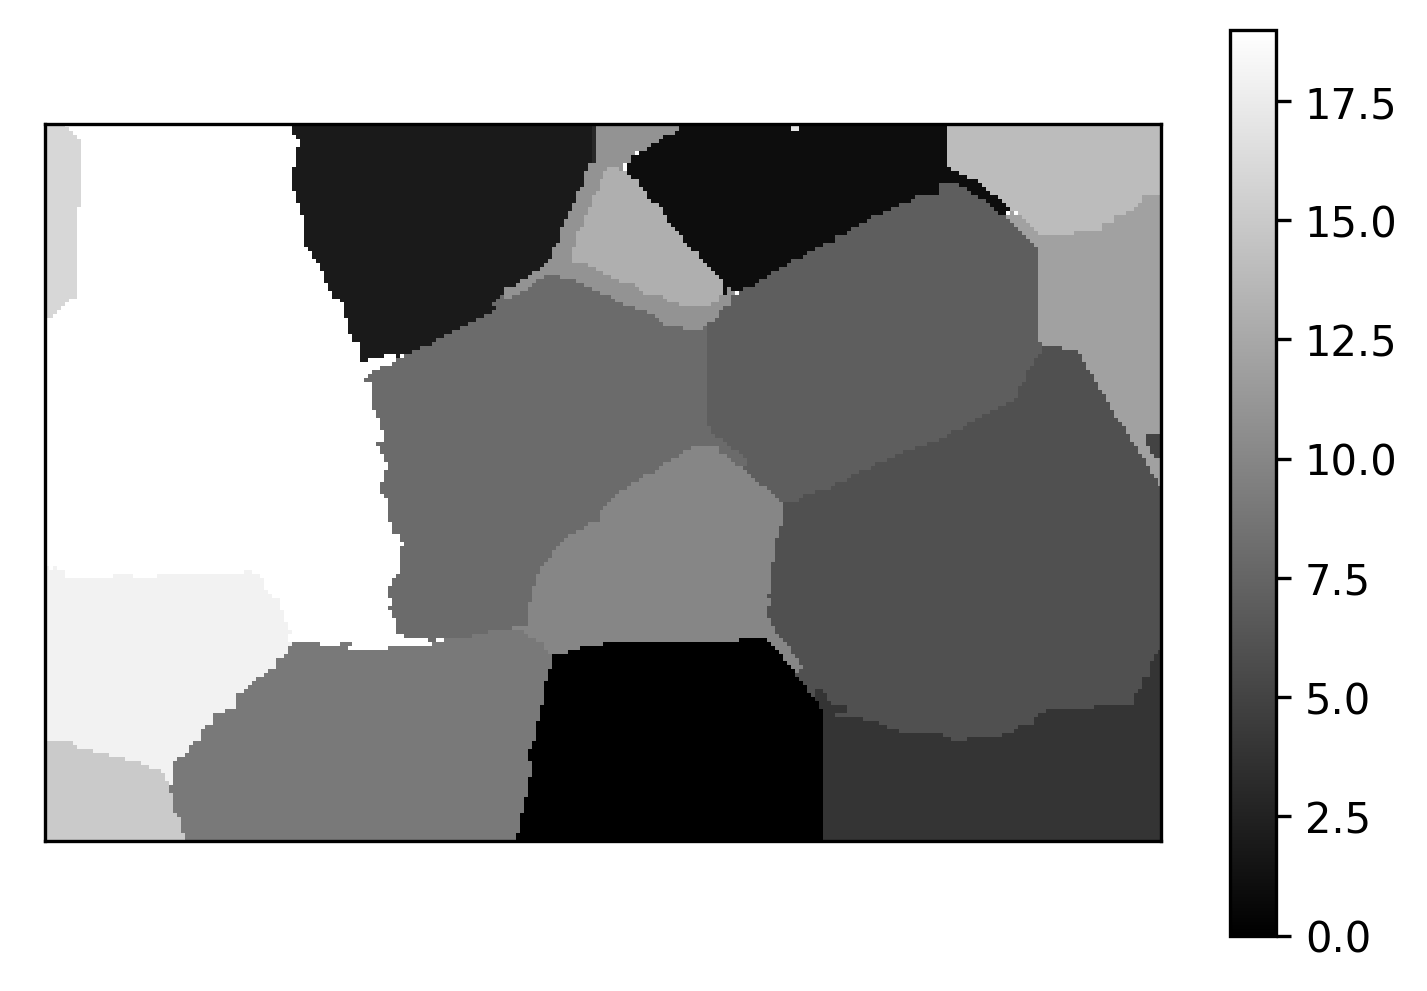

In [166]:
# Turn the flat array of cluster labels for each pixel into an image.
# This results in large regions with pixel values between 0 to 25.
clusters_img = clusters.reshape(scaled_grains.shape)

plt.imshow(clusters_img, cmap=plt.cm.gray)
plt.colorbar()
plt.xticks(())
plt.yticks(())

What we really want is the boundaries, and we can use contour plots to do this.

([], <a list of 0 Text yticklabel objects>)

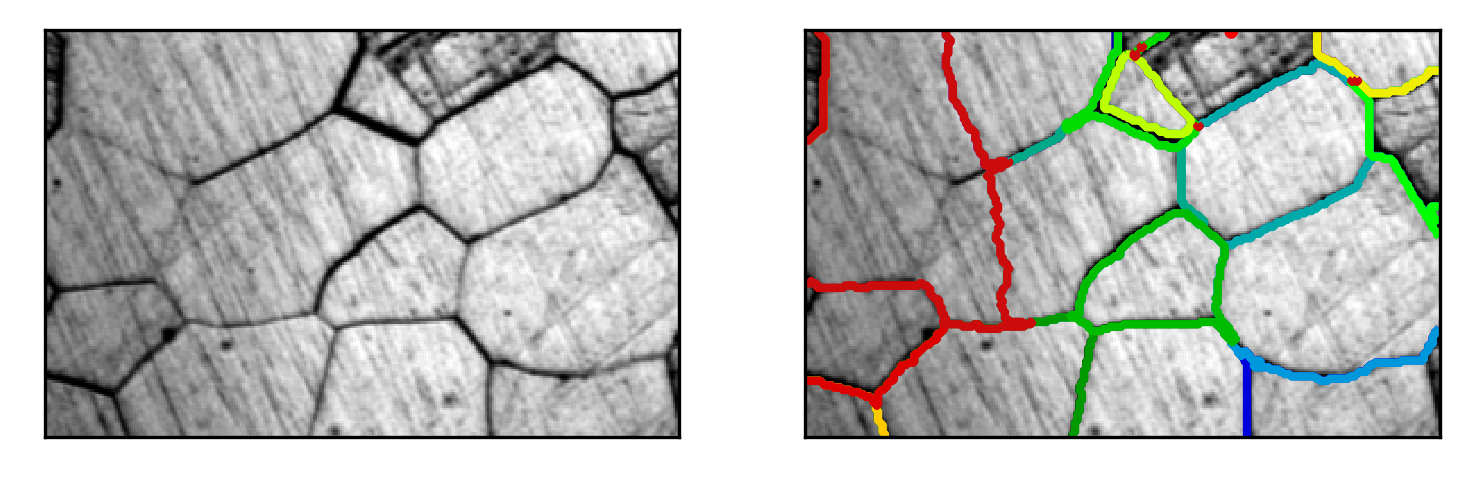

In [167]:
# Plot the original image
plt.figure()
plt.subplot(1,2,1)
plt.imshow(scaled_grains, cmap=plt.cm.gray)
plt.xticks(())
plt.yticks(())


# Plot the image with contours (boundaries of the regions numbered between 0 and 25)
plt.subplot(1,2,2)
plt.imshow(scaled_grains, cmap =plt.cm.gray)
# Plot all the contours, and color them differently
for l in range(k):
    plt.contour(clusters_img == l, colors=[plt.cm.nipy_spectral(l / float(k))])
plt.xticks(())
plt.yticks(())

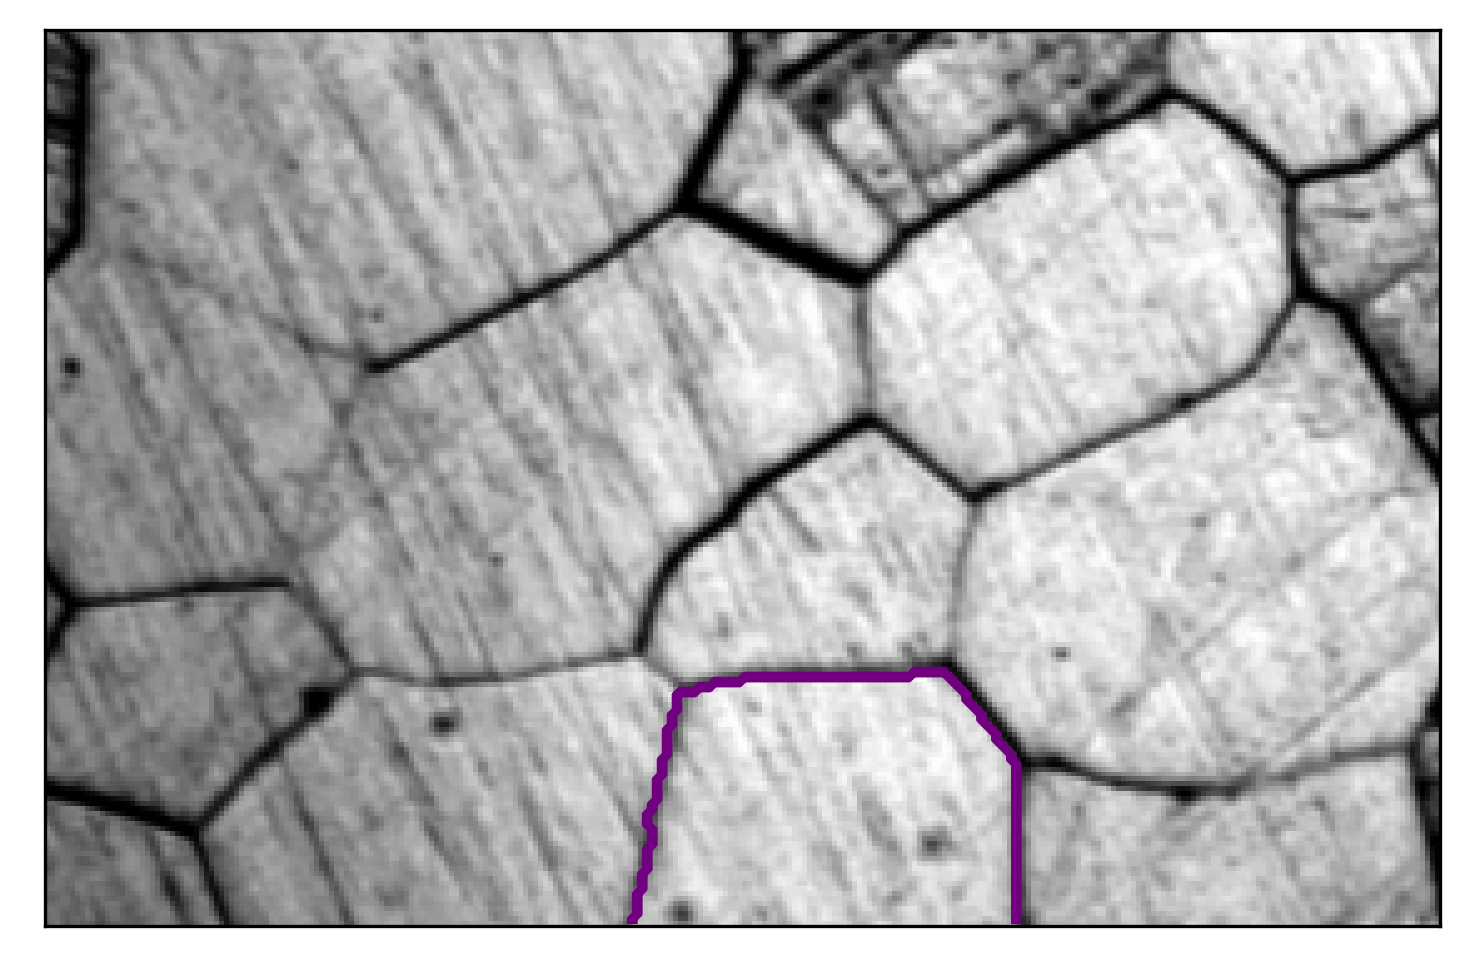

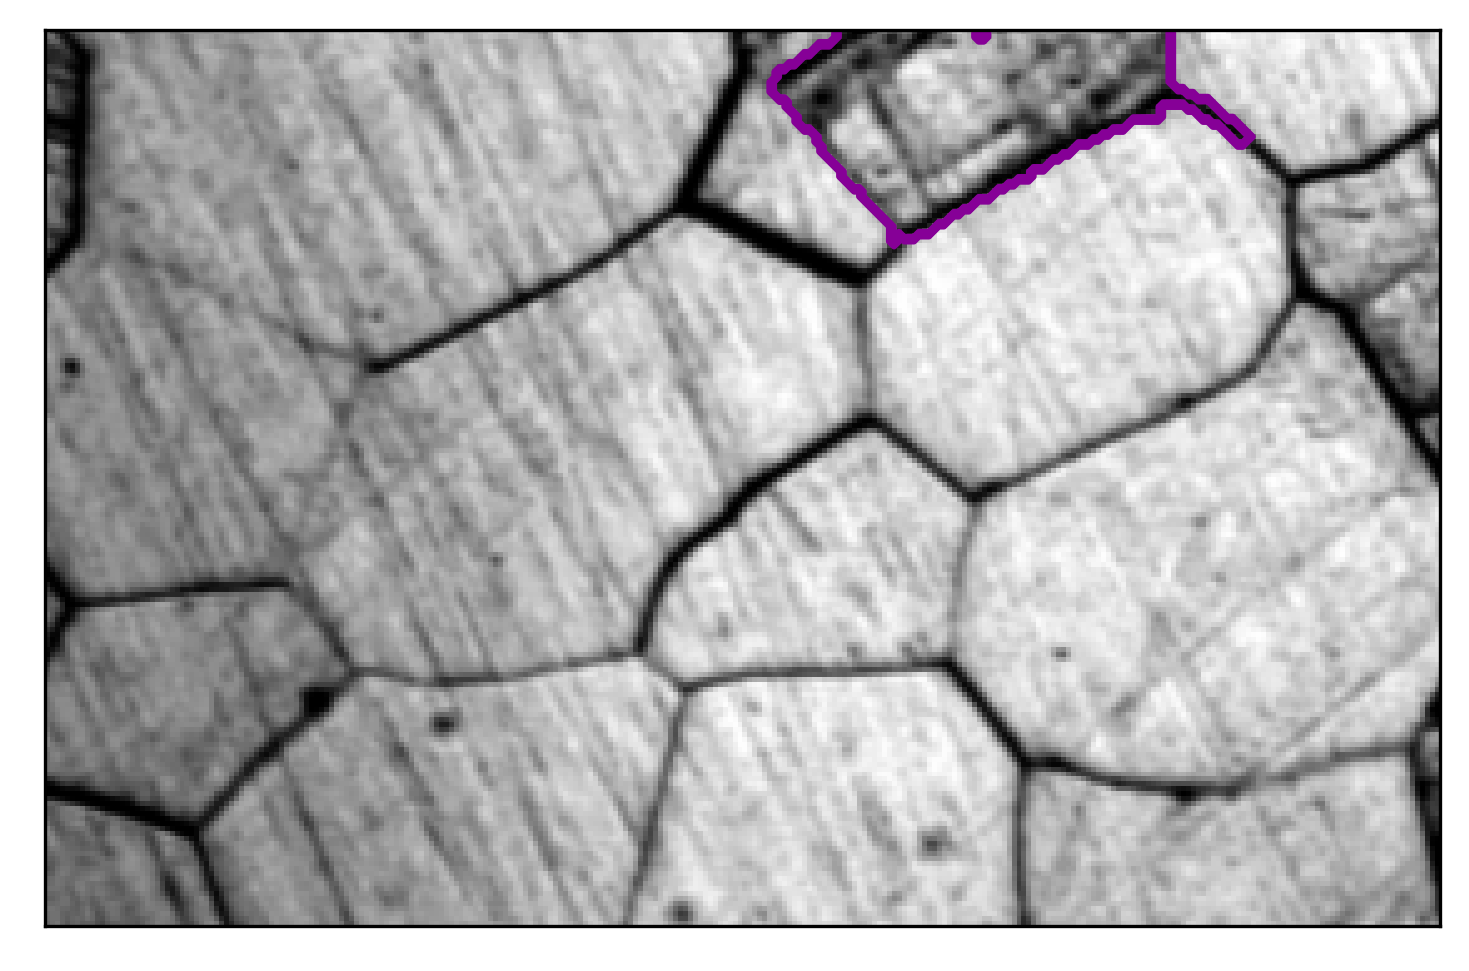

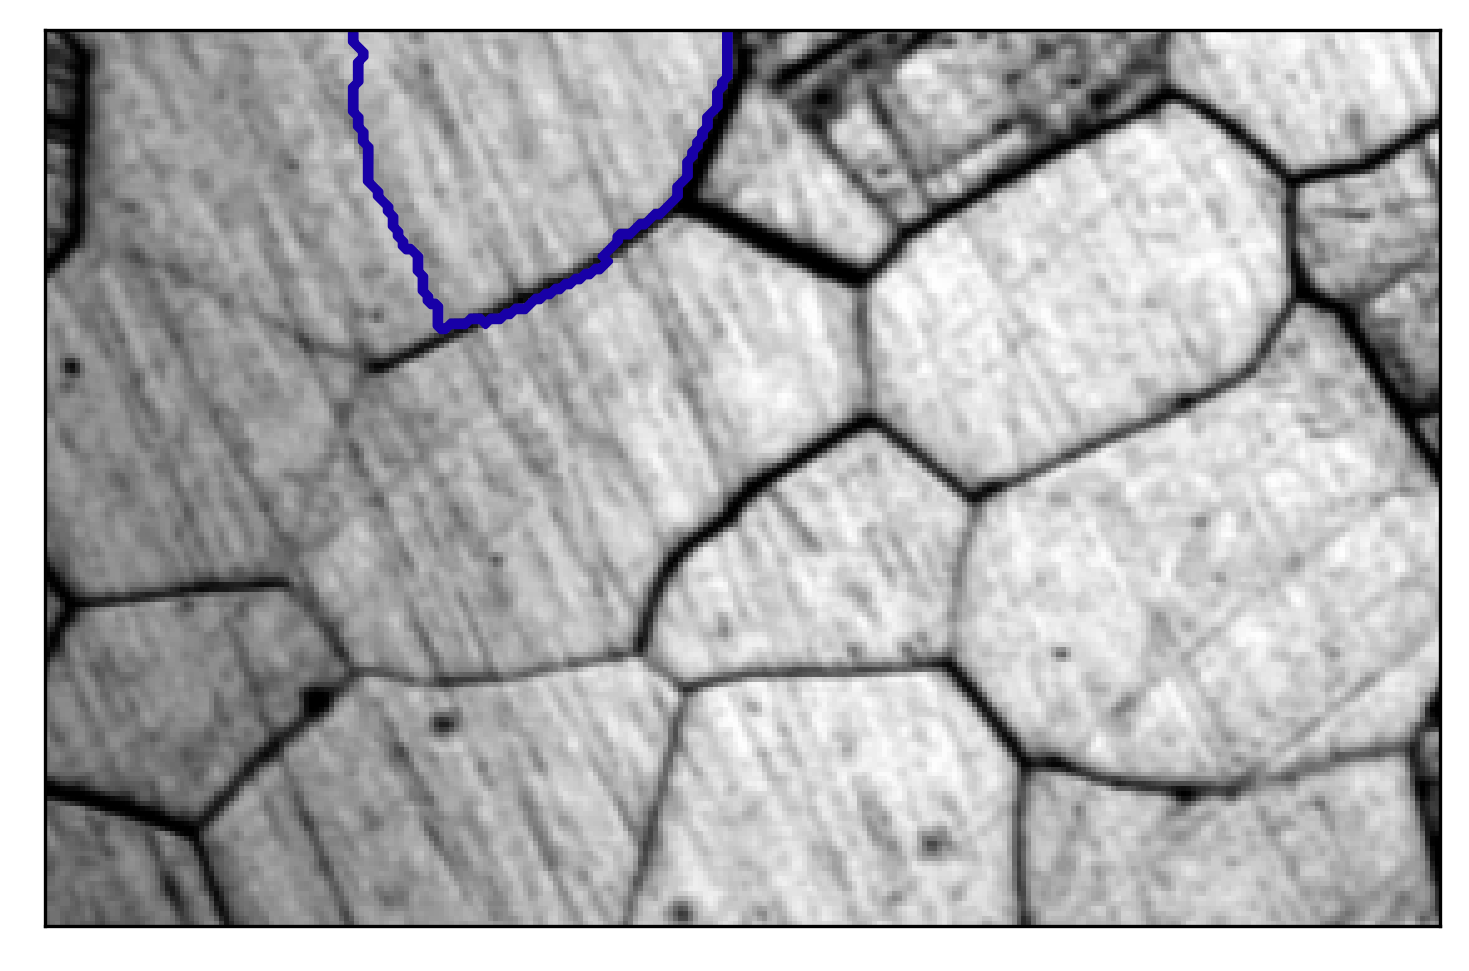

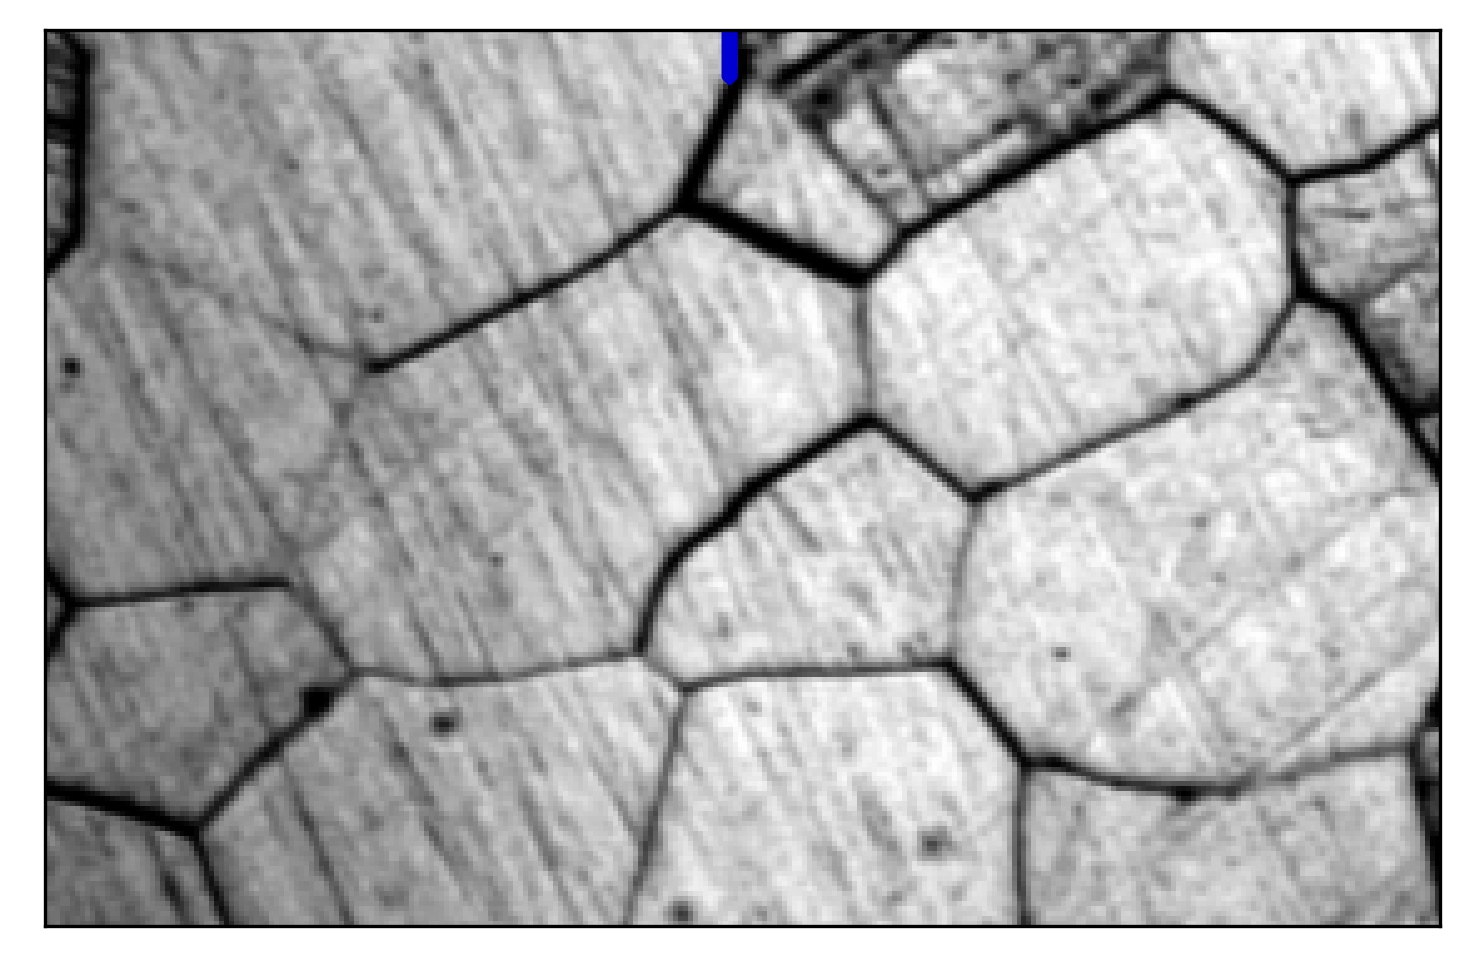

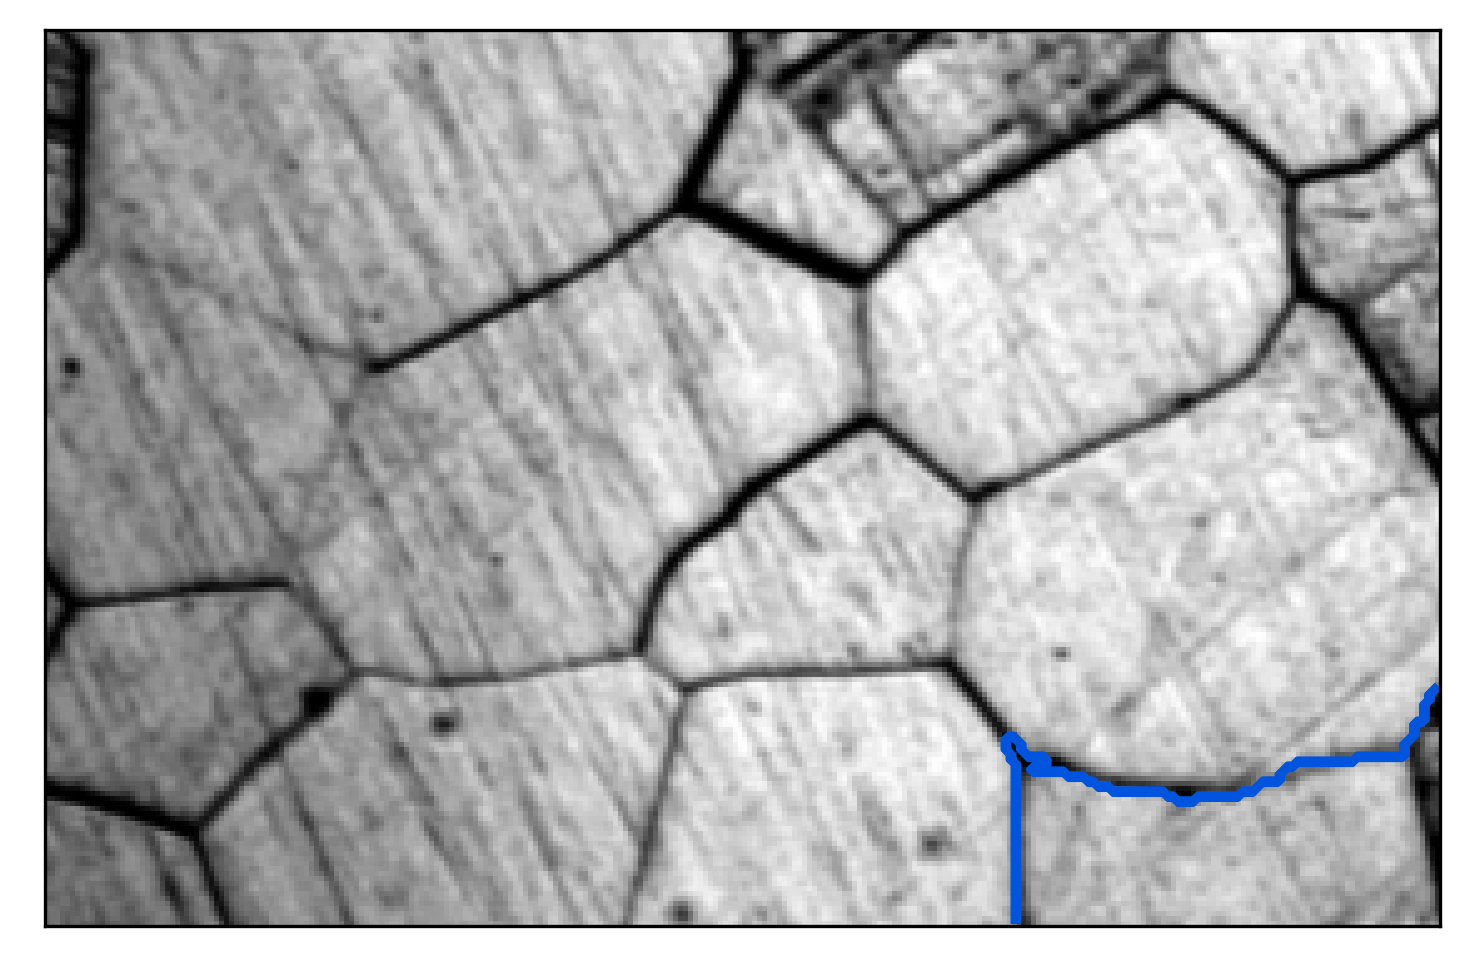

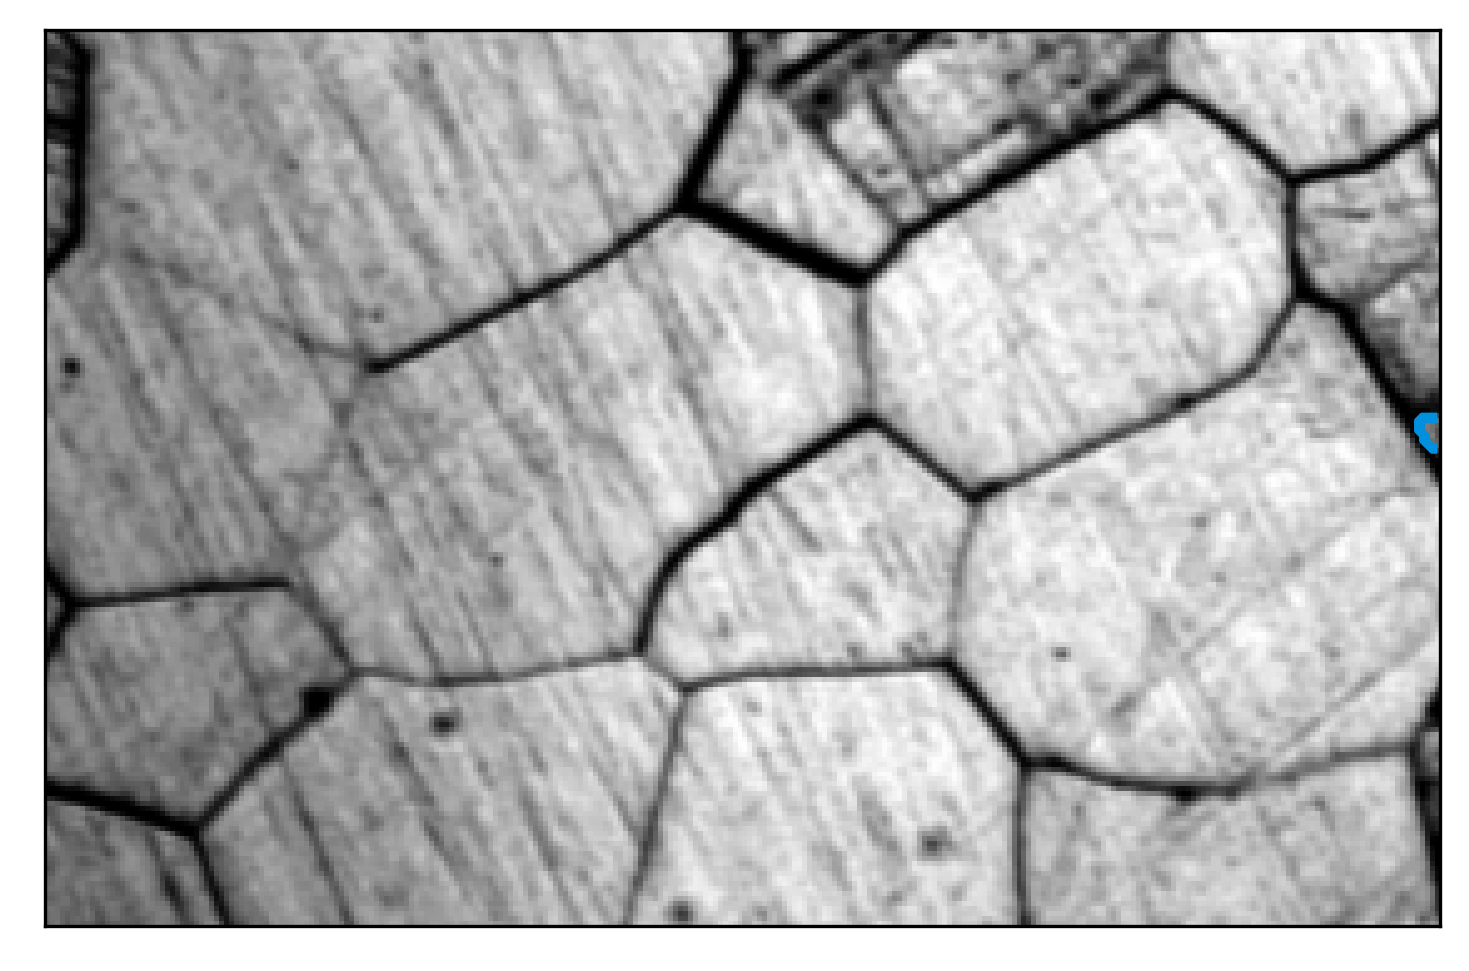

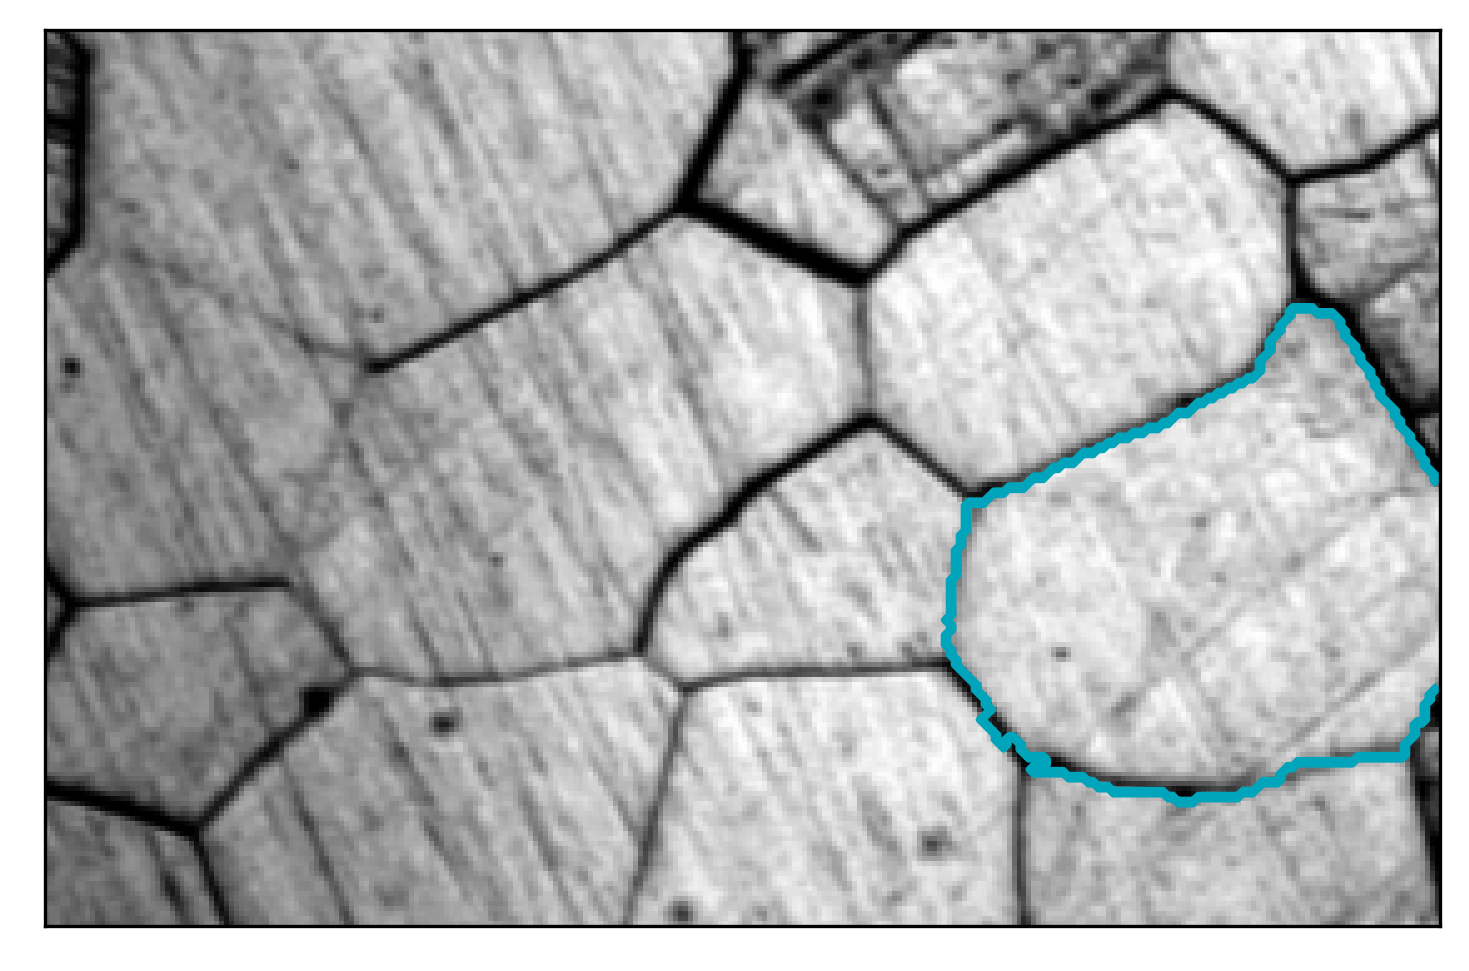

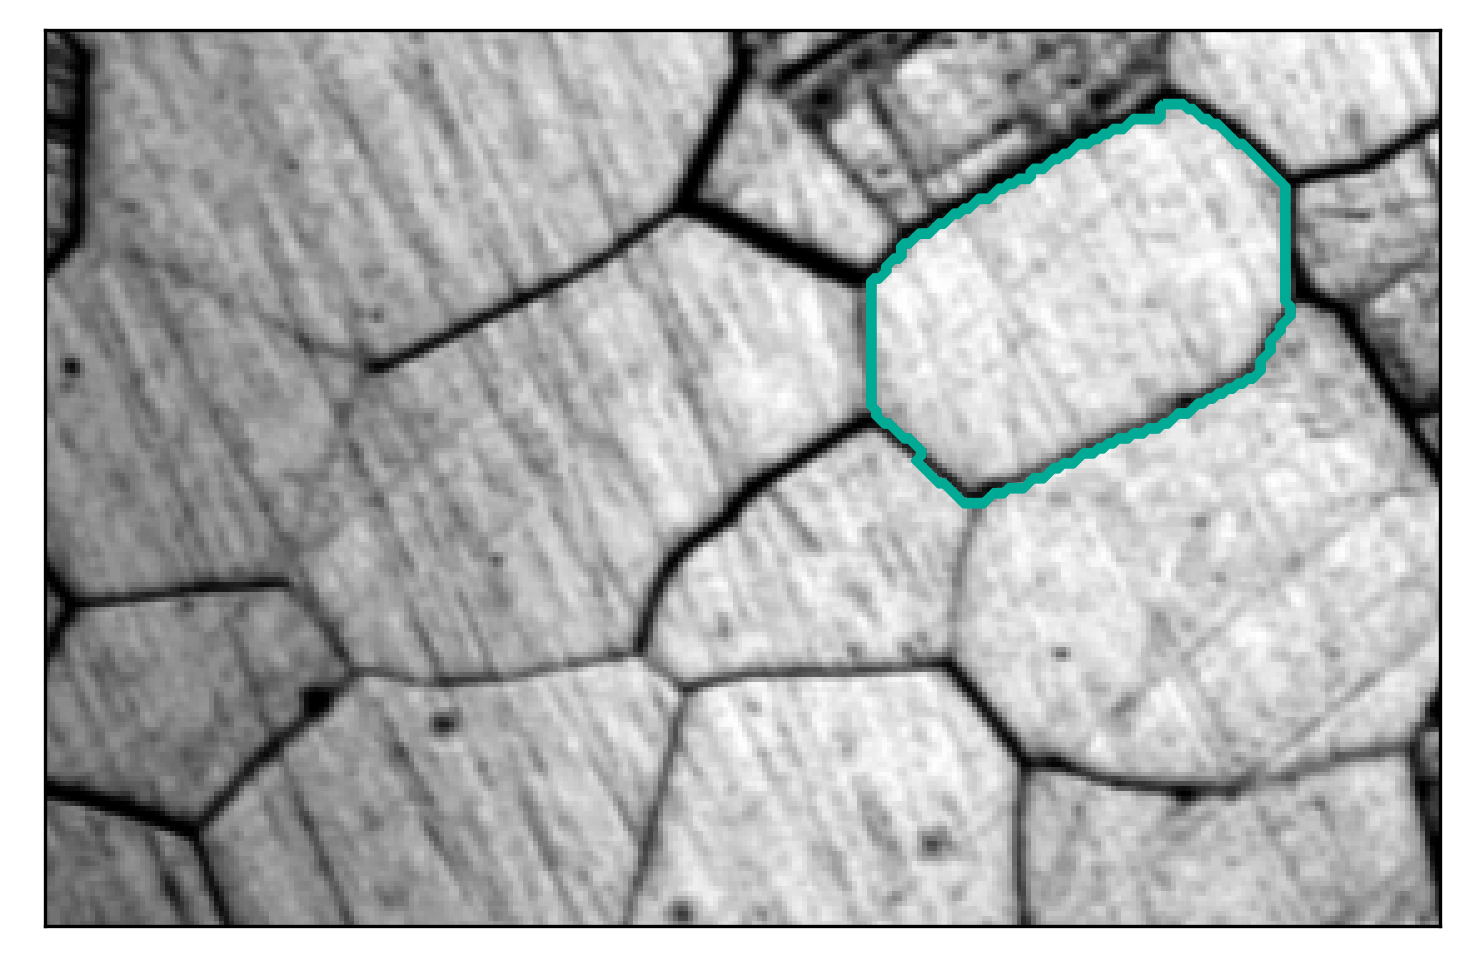

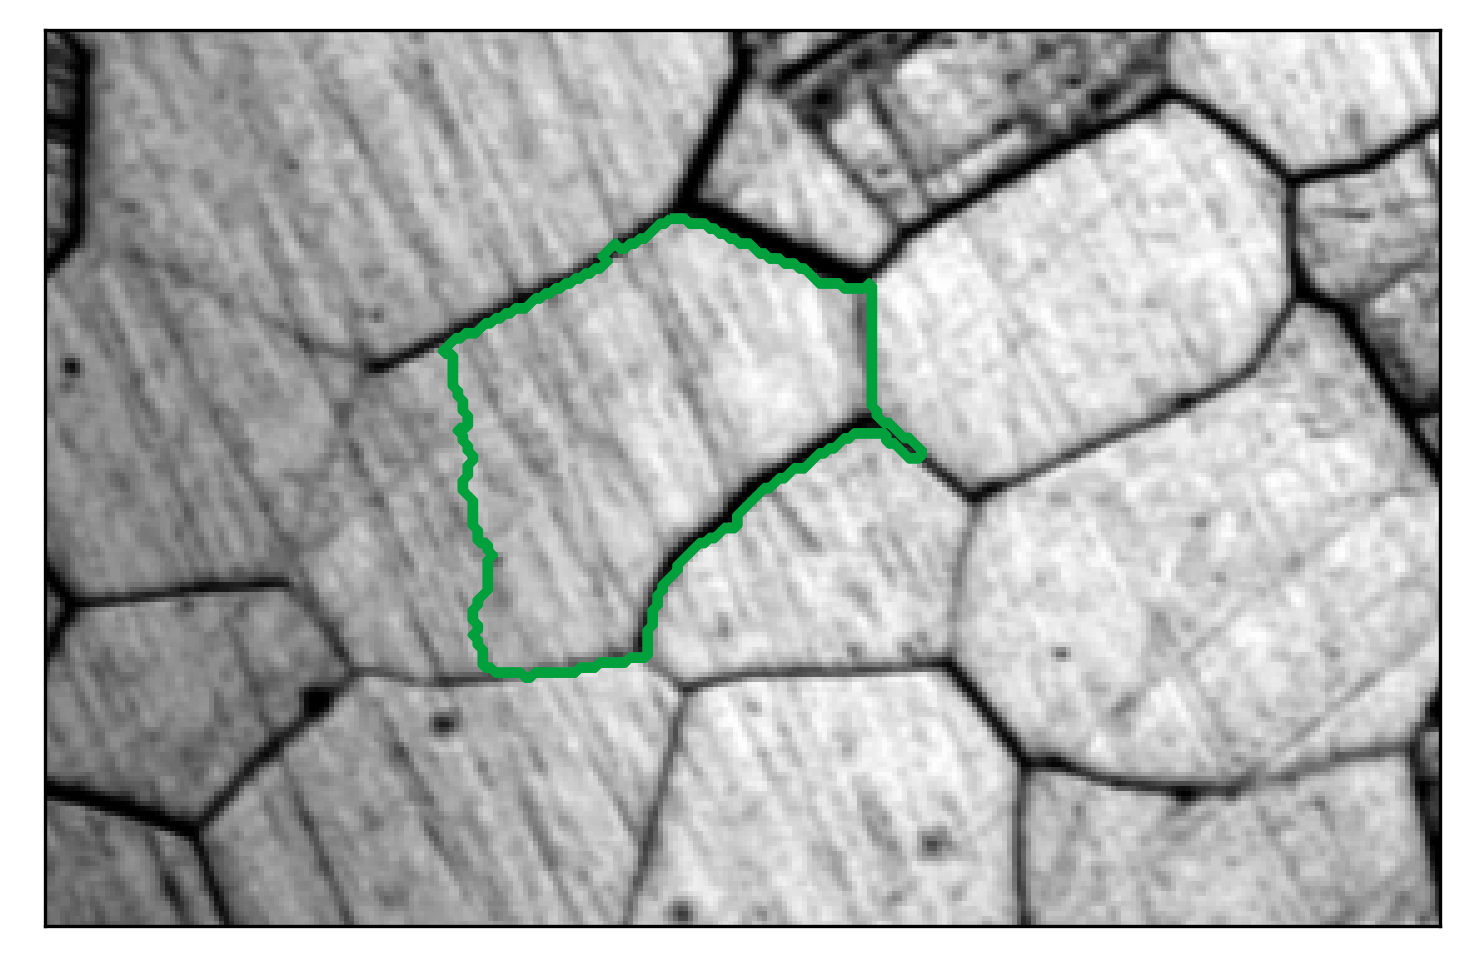

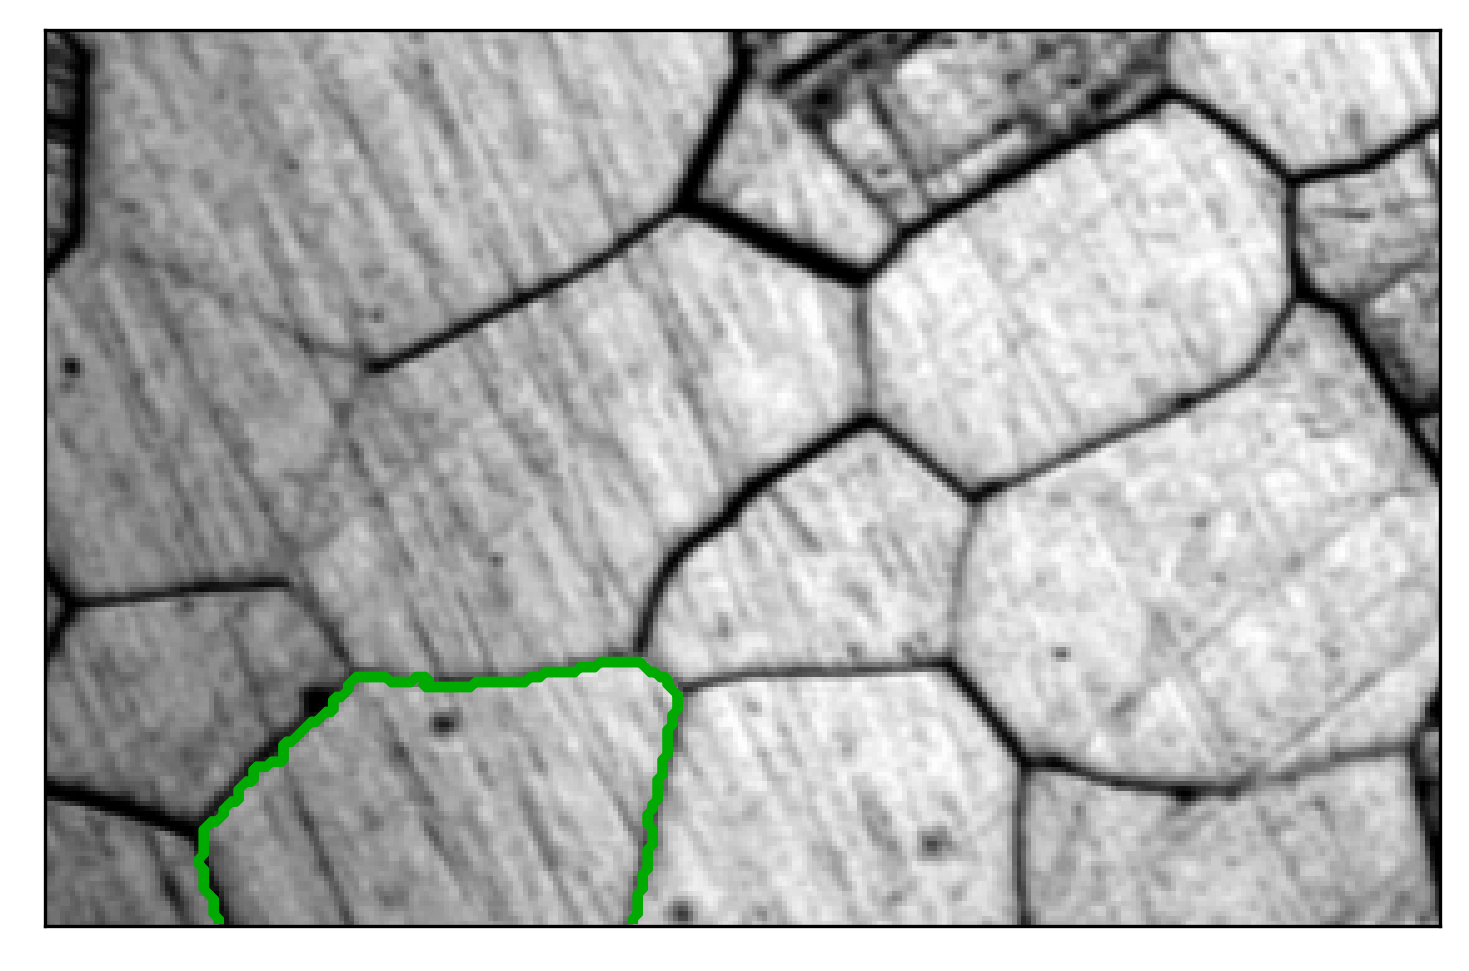

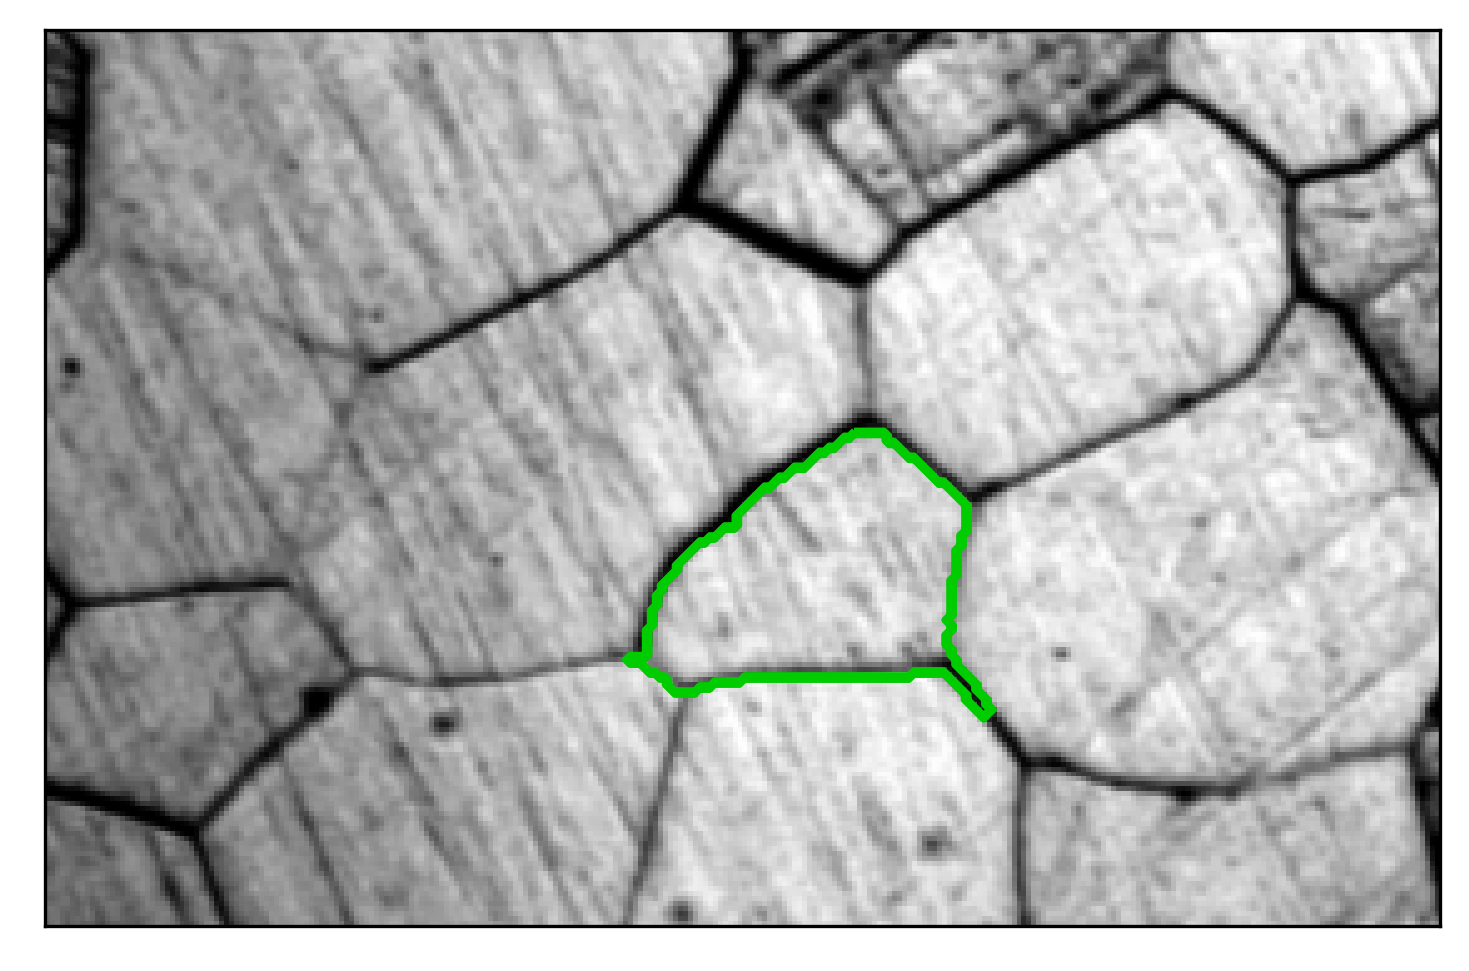

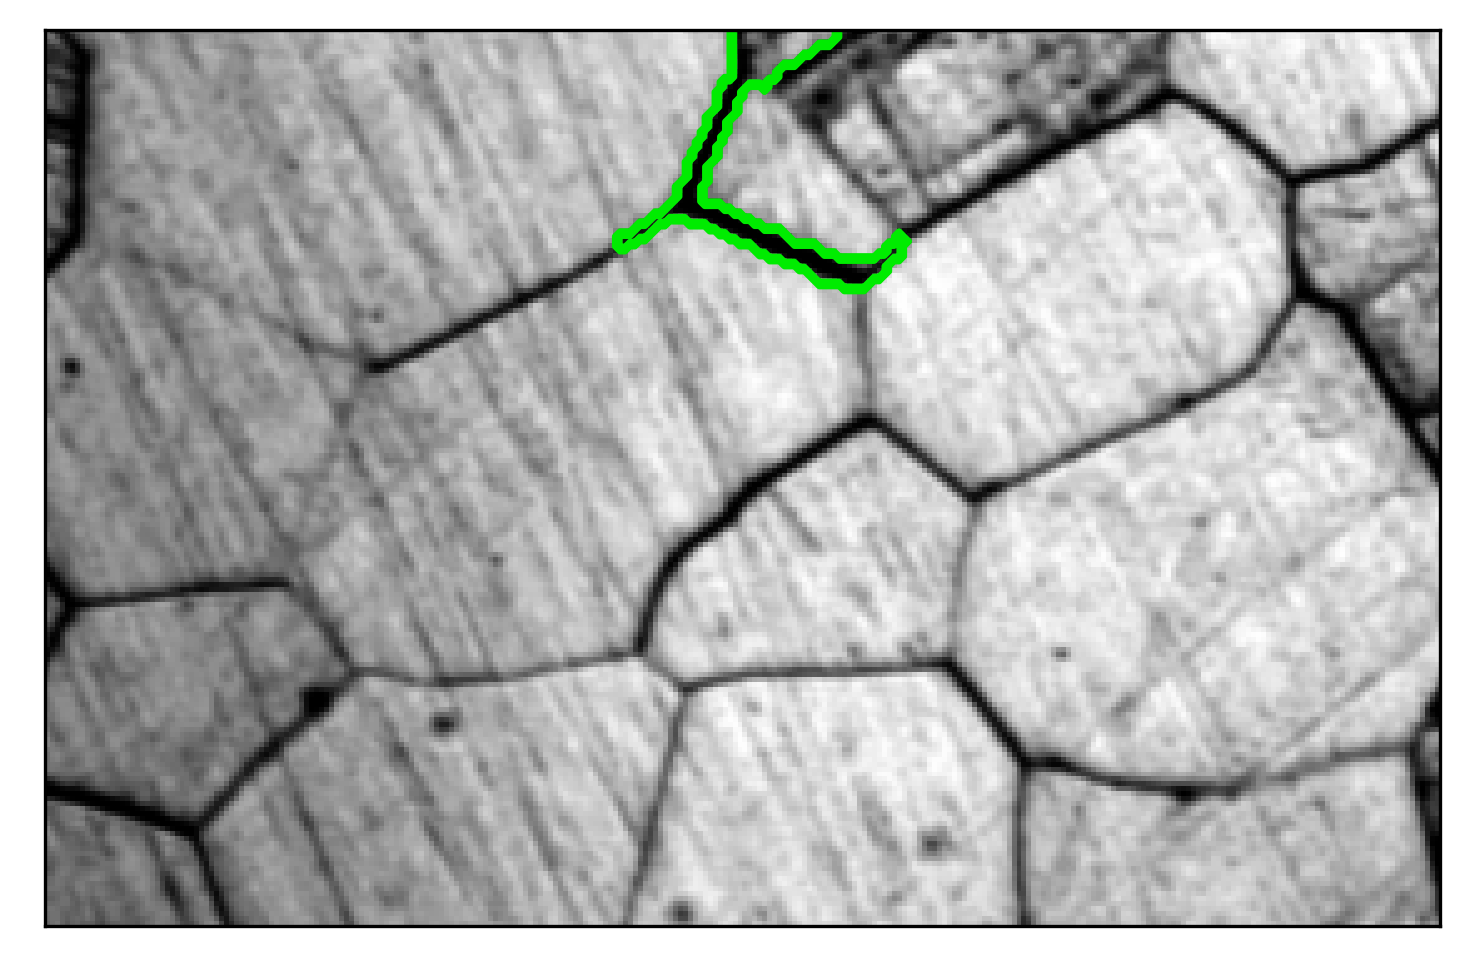

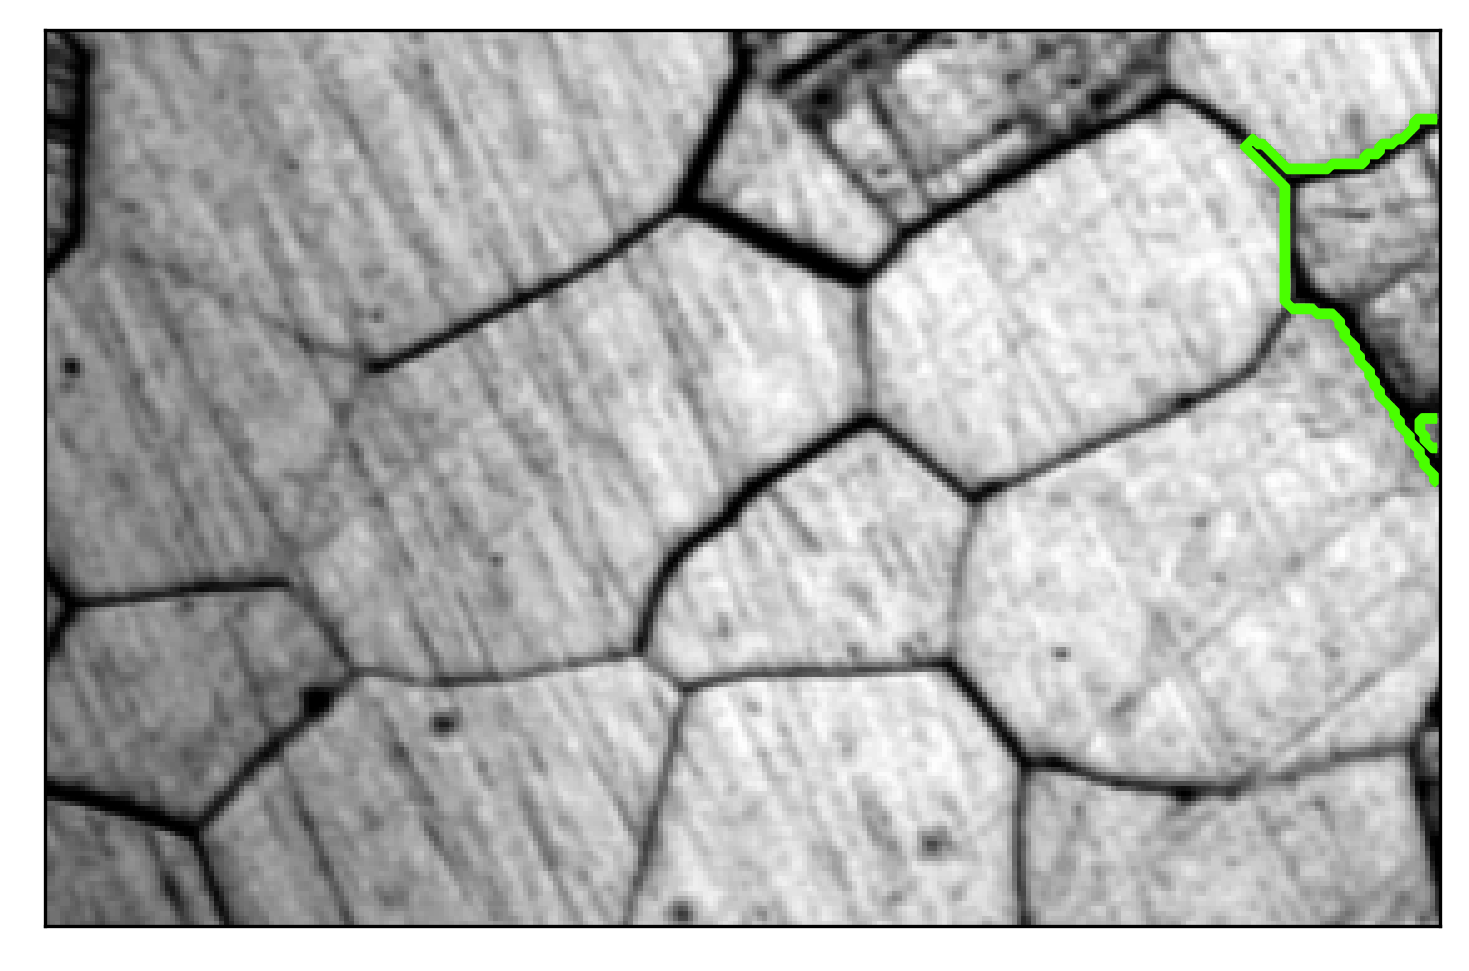

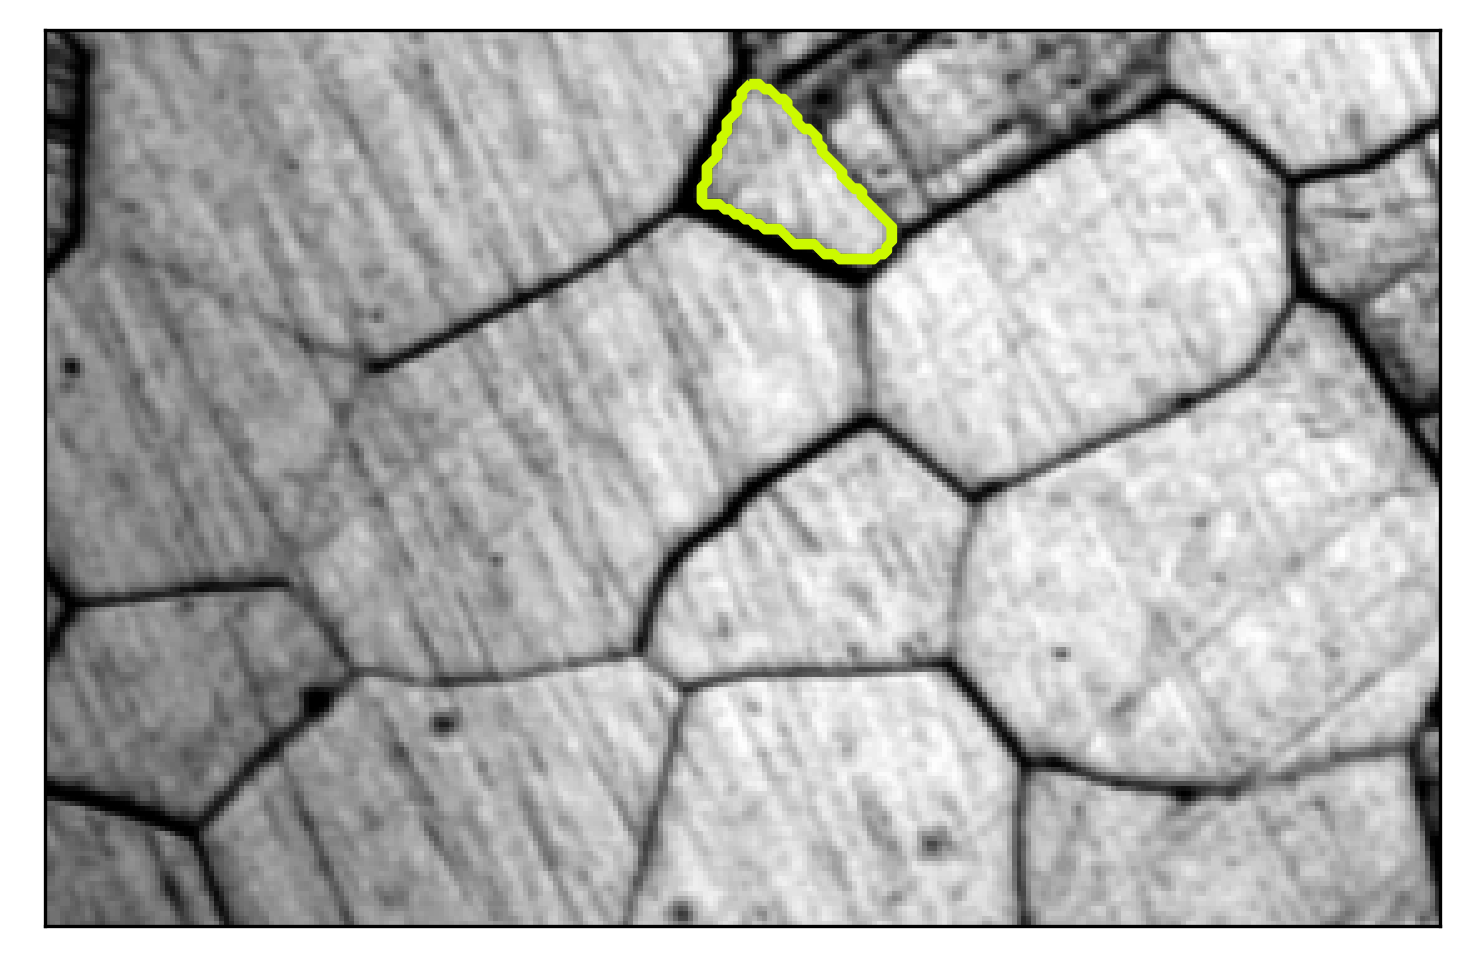

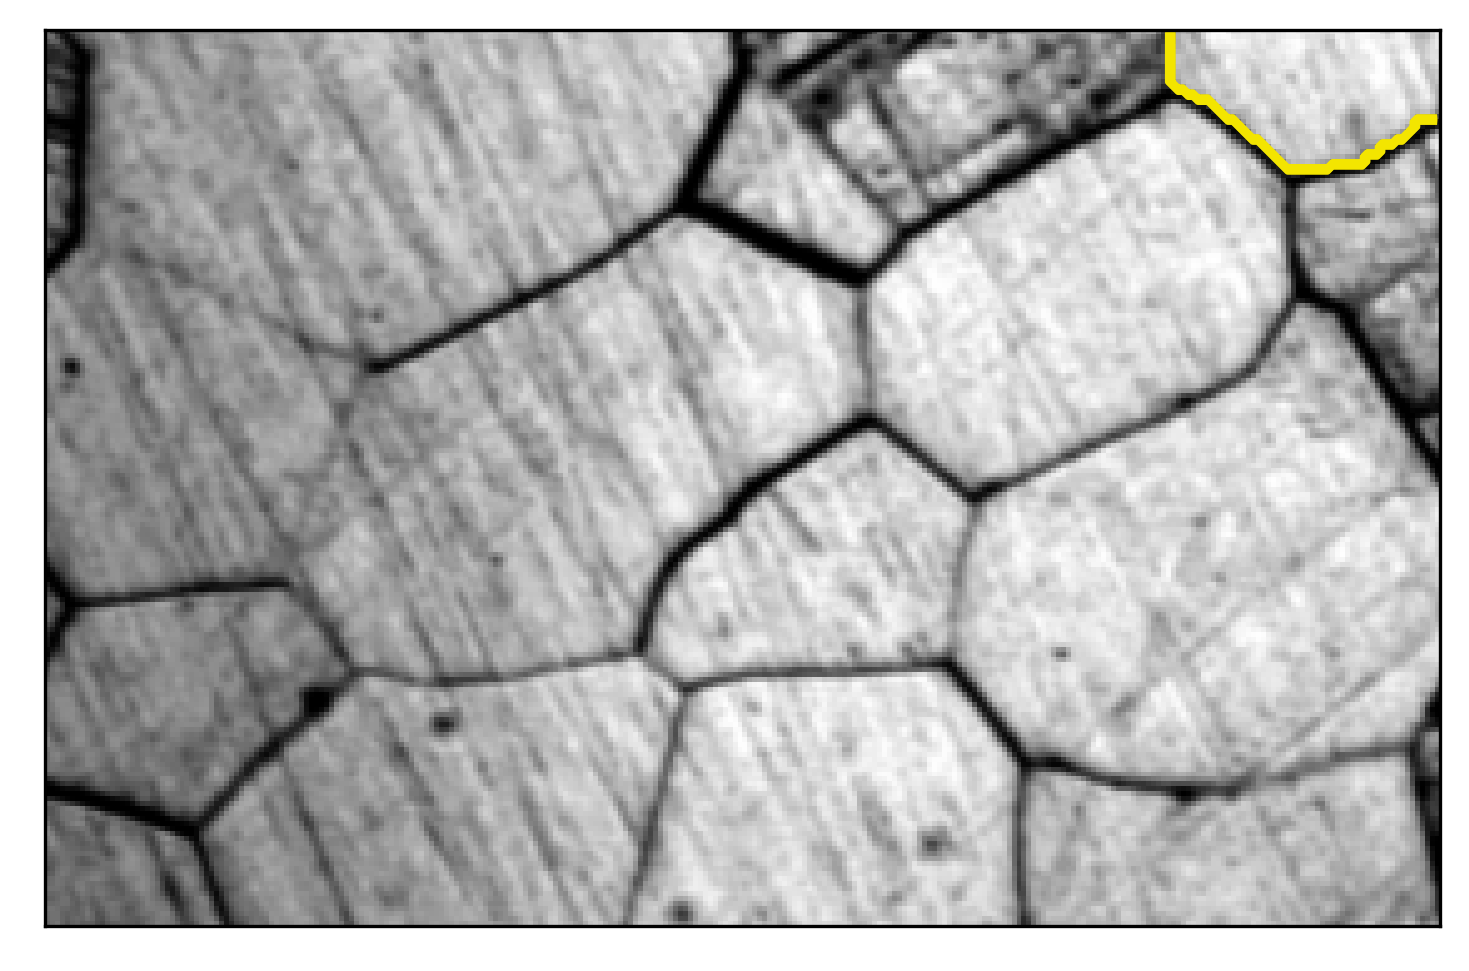

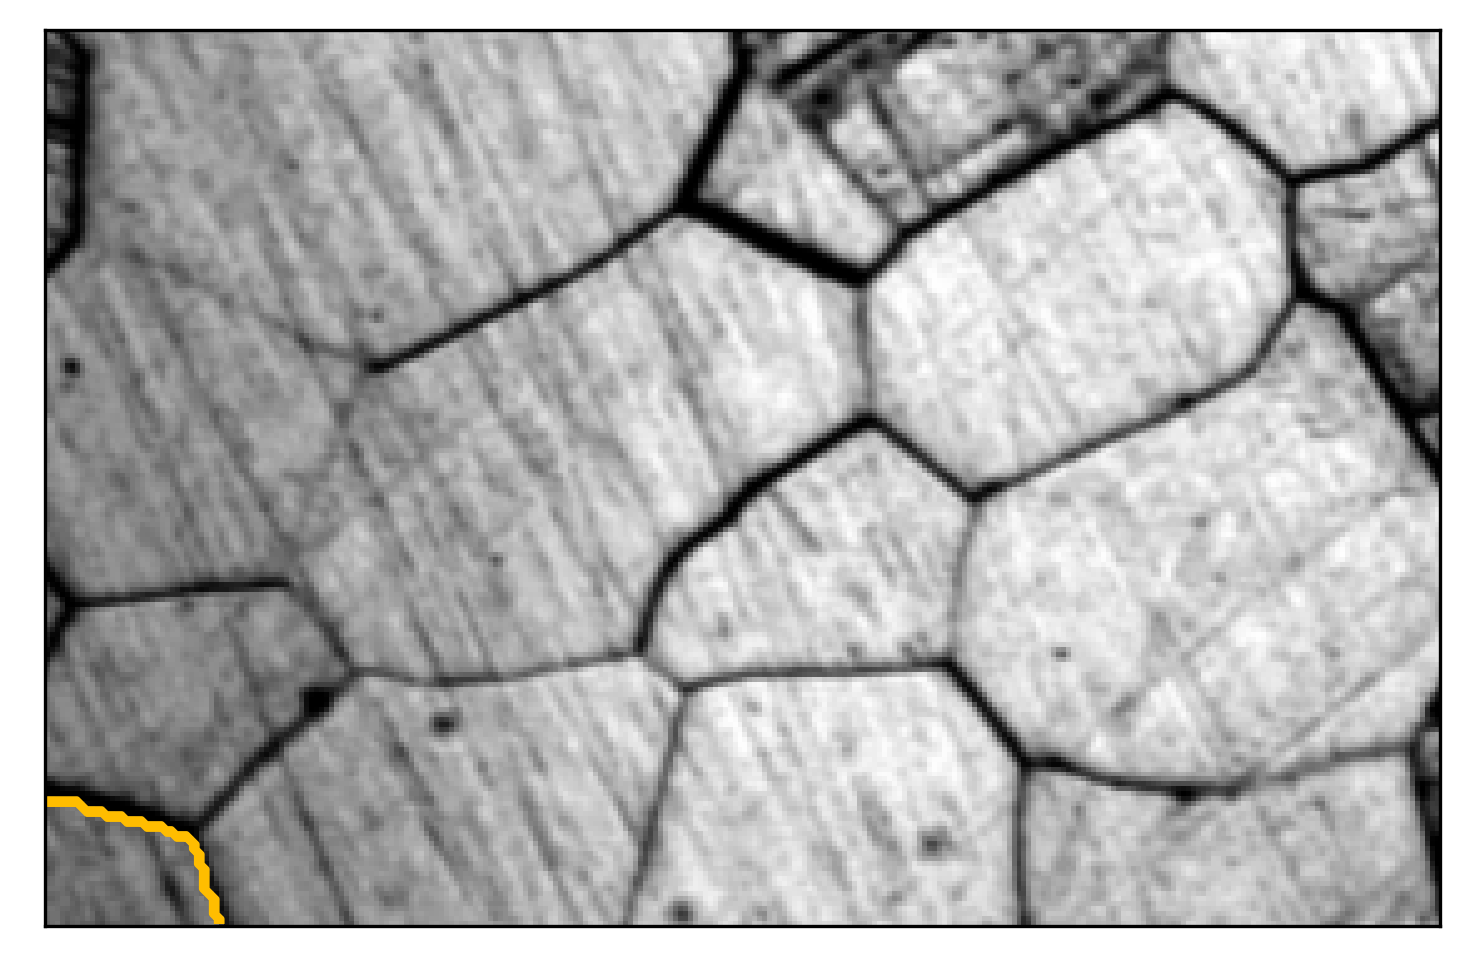

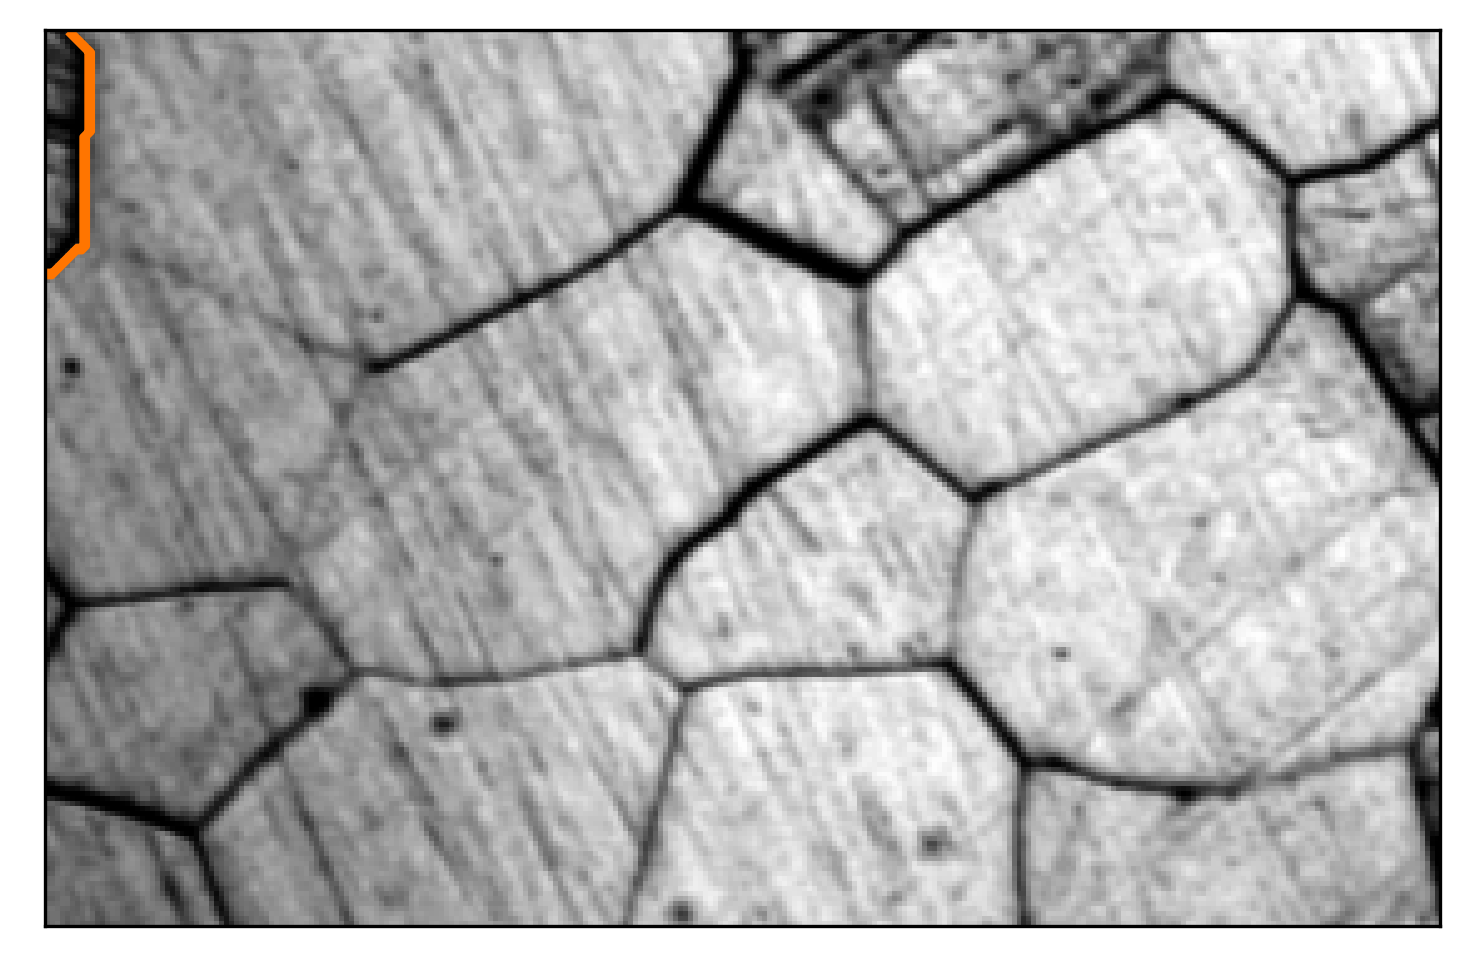

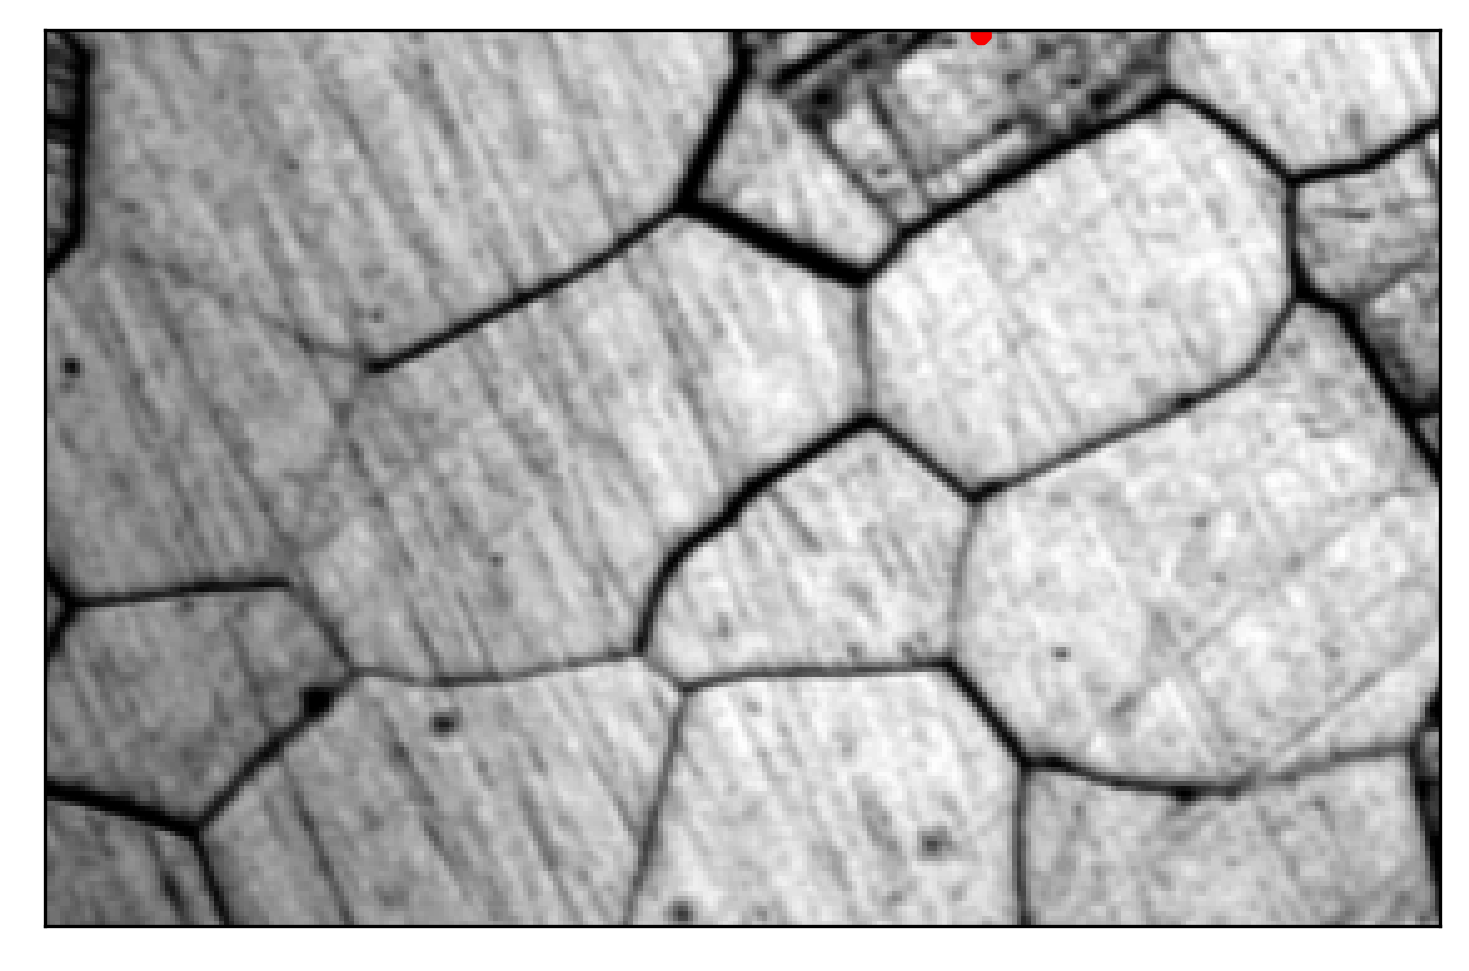

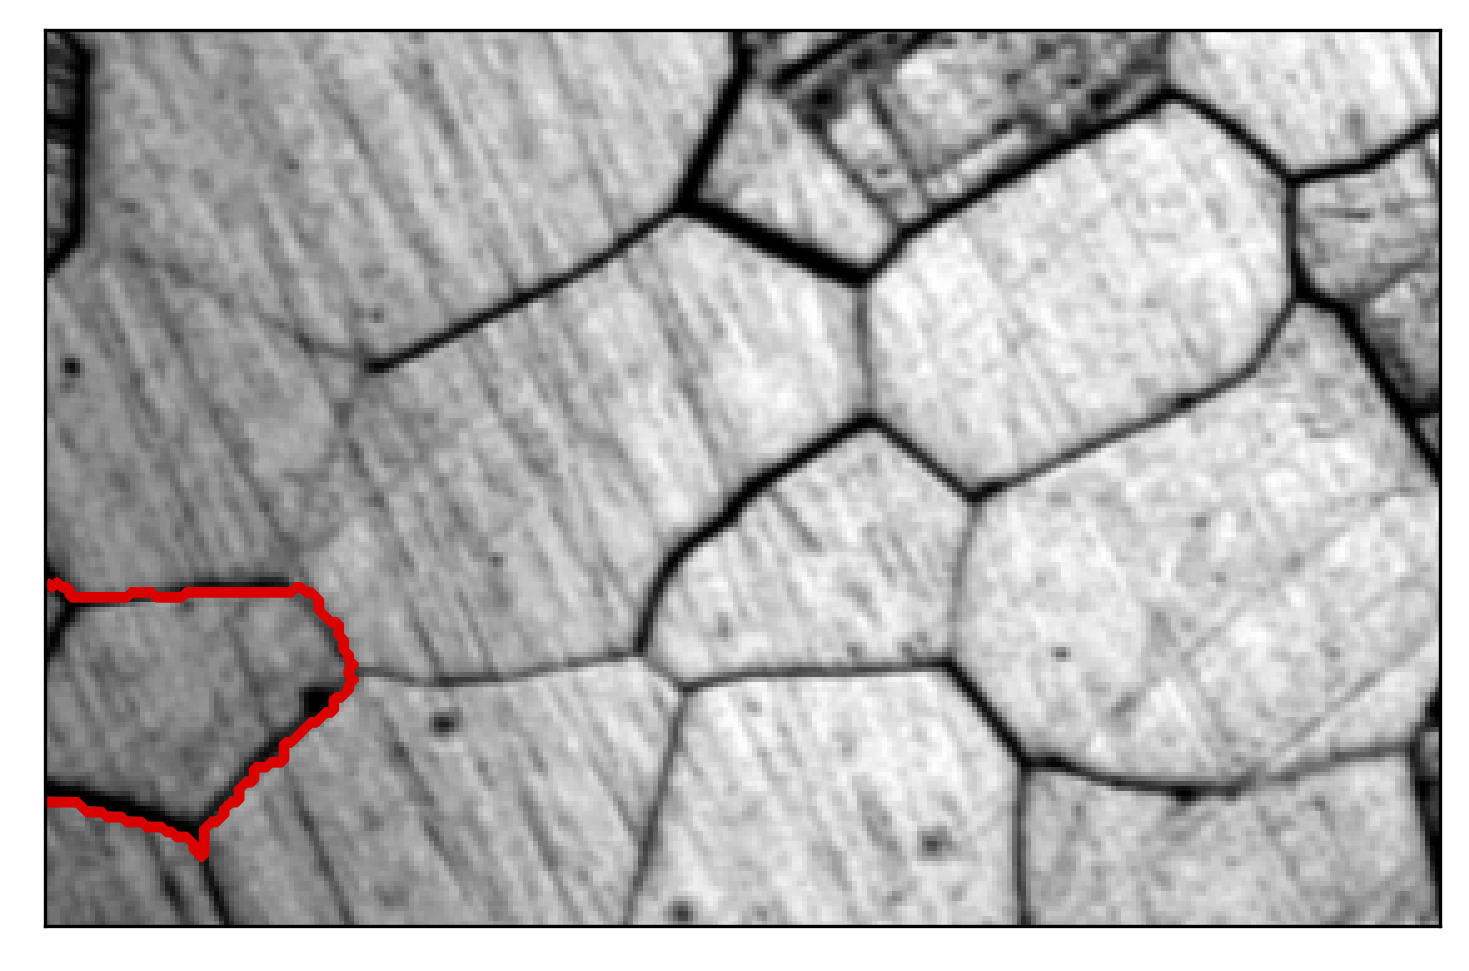

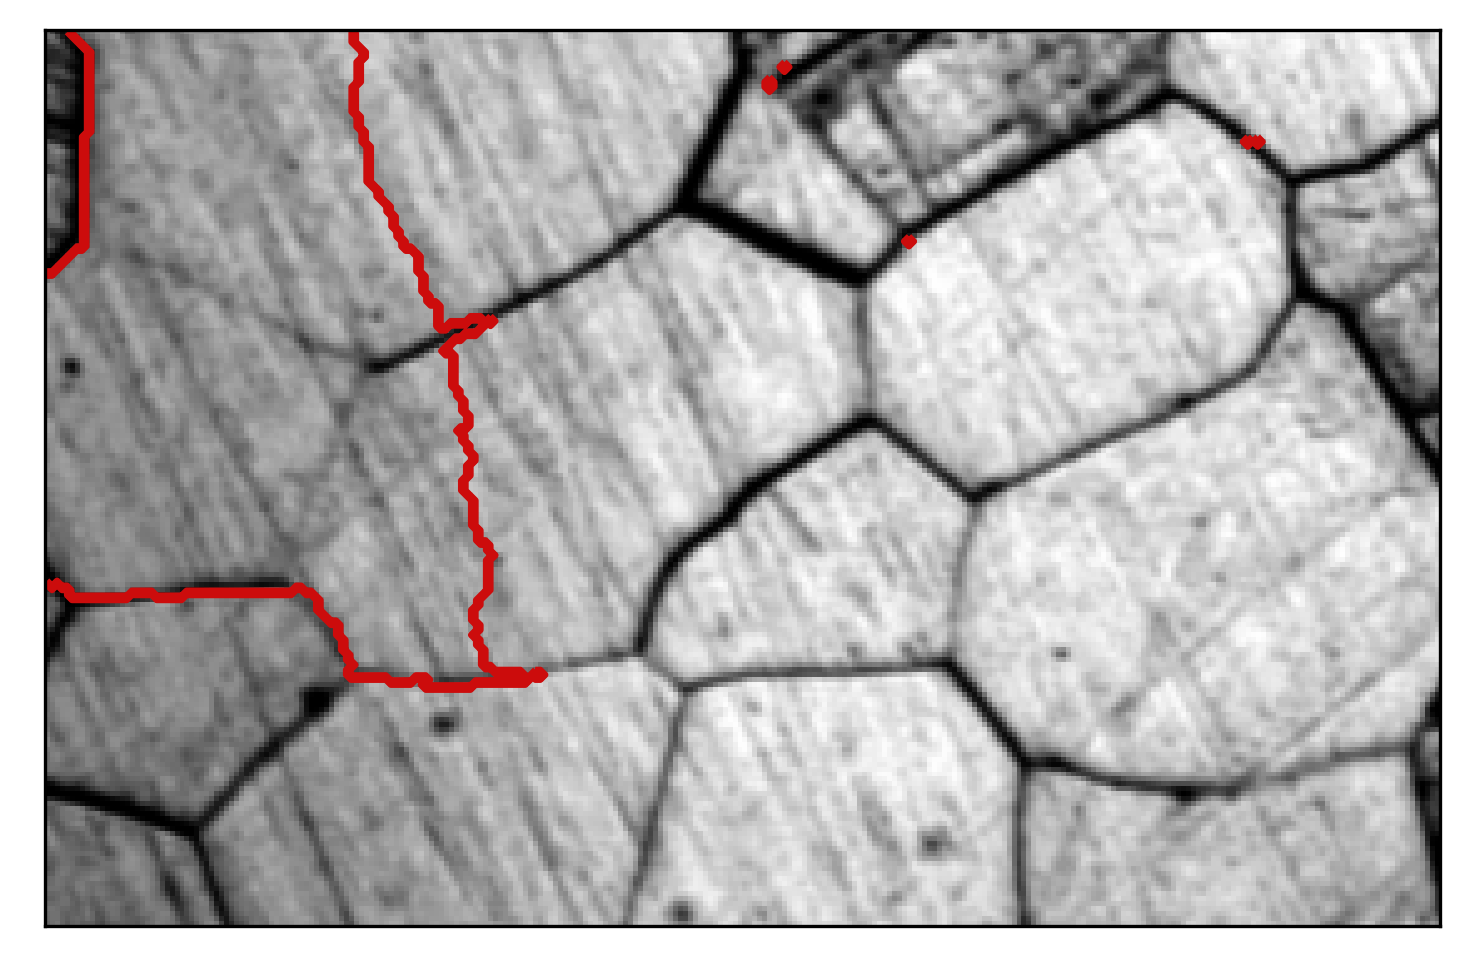

In [168]:
# Plot each cluster 
for l in range(k):
    plt.imshow(scaled_grains, cmap=plt.cm.gray)
    plt.contour(clusters_img == l, colors=[plt.cm.nipy_spectral((l+1) / float(k+1))])
    plt.xticks(())
    plt.yticks(())
    plt.show()

We can get statistics such as grain size distributions

Text(0, 0.5, 'Frequency')

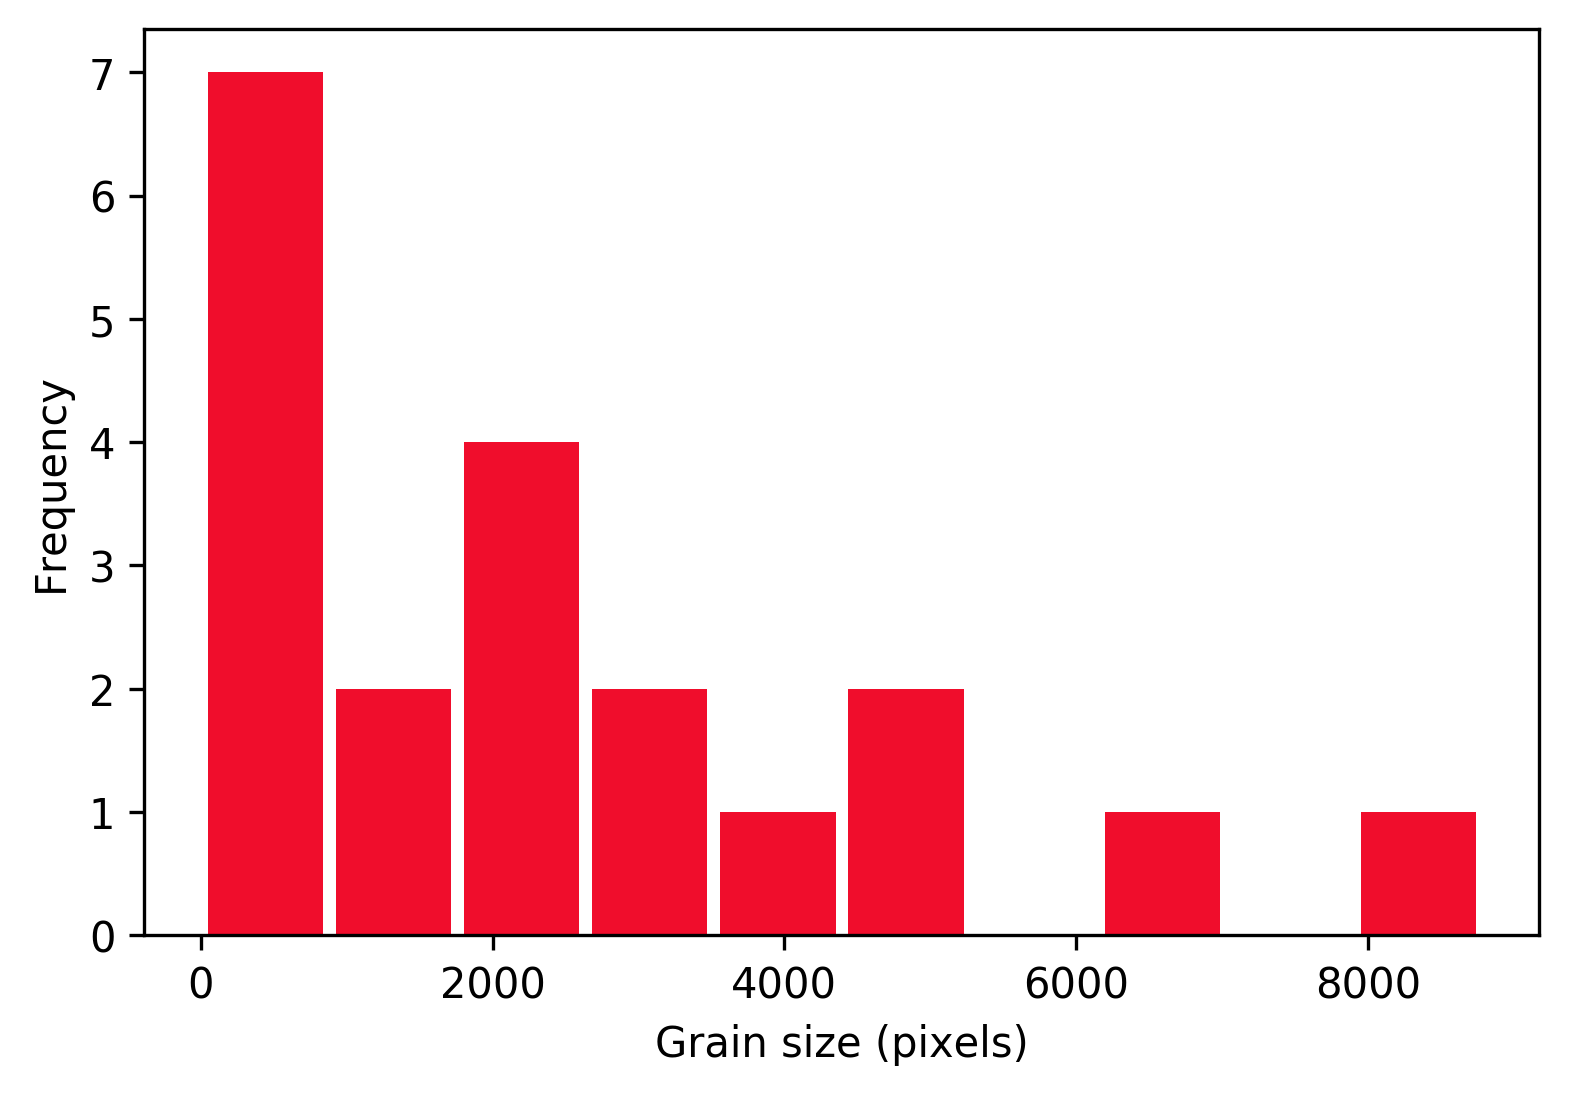

In [169]:
grain_sizes = np.zeros(k)

for i in range(k):
    grain_sizes[i] = np.sum(clusters == i)
    
plt.hist(grain_sizes, rwidth = 0.9)
plt.xlabel("Grain size (pixels)")
plt.ylabel("Frequency")

We saw that many of the "grains" weren't really grains. We can get rid of these by removing, e.g. the lower 25-th percentile

Text(0, 0.5, 'Frequency')

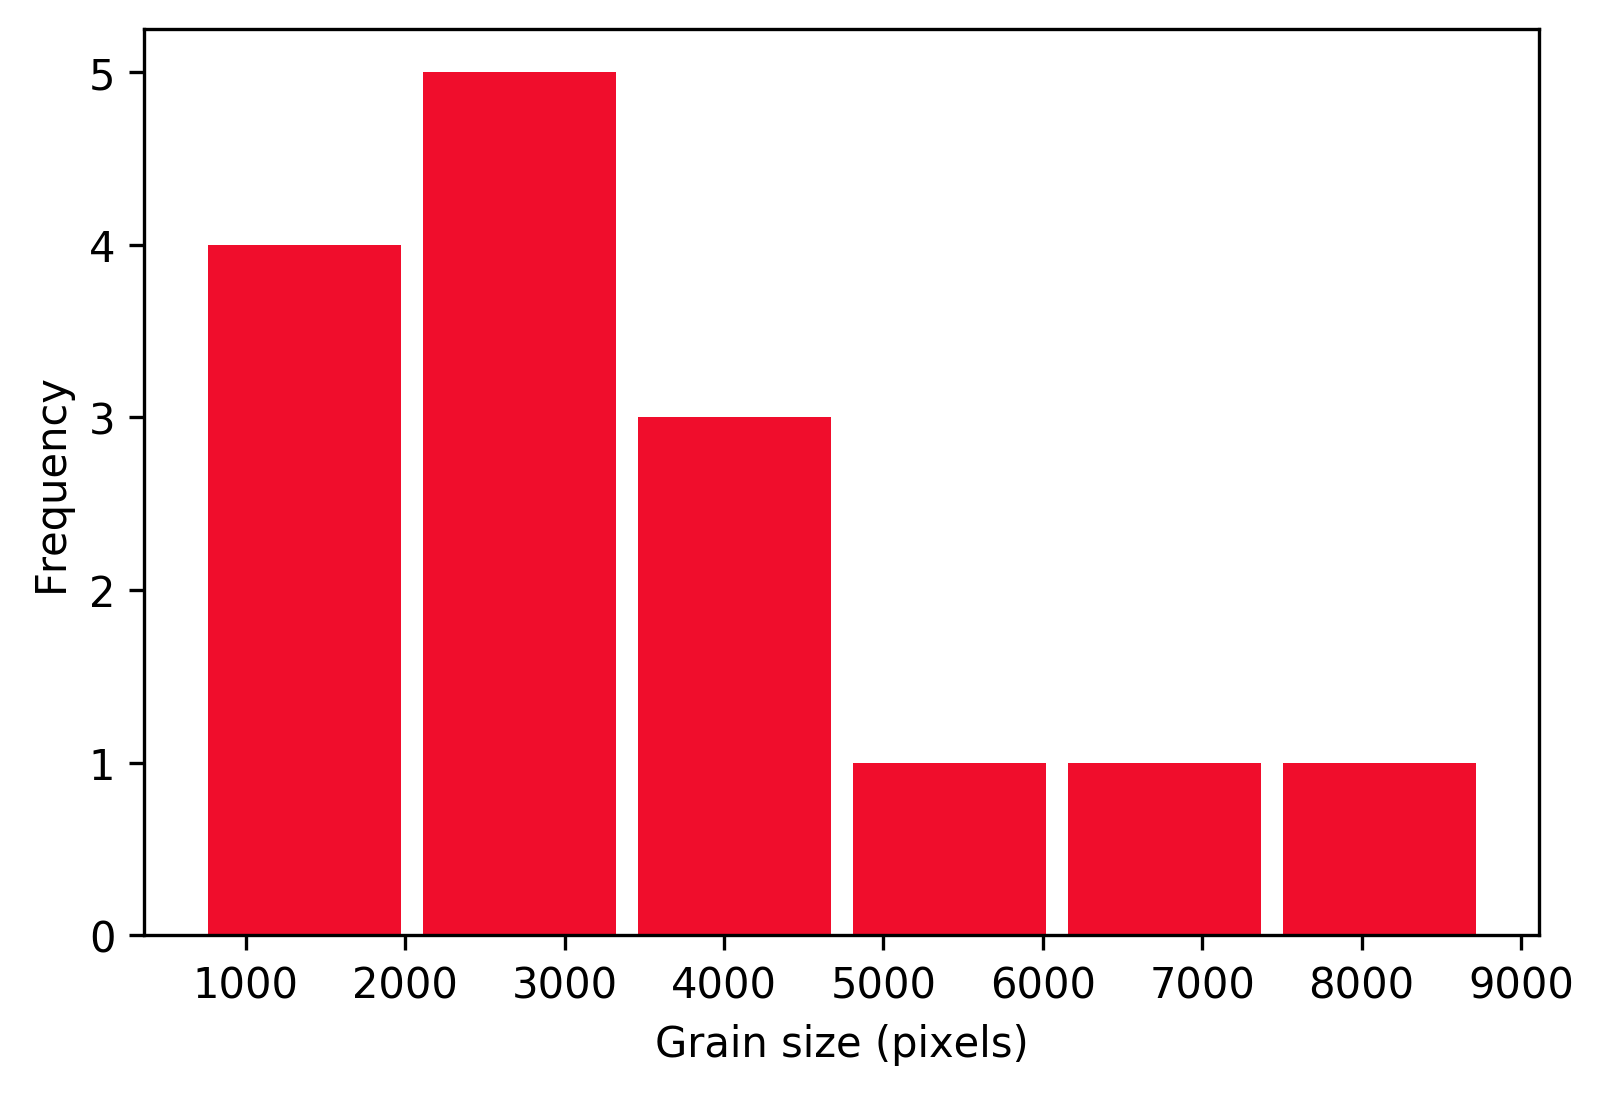

In [172]:
I_big = grain_sizes > np.percentile(grain_sizes, 25)
grain_sizes_big = grain_sizes[I_big]
plt.hist(grain_sizes_big, bins=6, rwidth = 0.9)
plt.xlabel("Grain size (pixels)")
plt.ylabel("Frequency")

There are several parameters you can play around with to get better results if you'd like. For example, you could change how to preprocess the images. You can also change the weightings for the graph (e.g. by simply changing the $\beta$ parameter), and the number of clusters $k$.